In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import xgboost as xgb
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import impute
from scipy.optimize import minimize
from scipy.stats import beta

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

#def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
#    y_true = data.get_label()
#    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
#balance_method = "weight"
#balance_method = "bagging"

DEFAULT_PARAMS = {
    'booster':'gblinear',
    'objective': 'binary:logistic',
    'verbosity': 2,
    'seed':2112,
    'eta': 0.005,
}

In [8]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):
    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        100 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = xgb.DMatrix(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
            )
            try:
                model = xgb.train(
                    params=model_params,
                    dtrain=train_dset,
                    num_boost_round=num_iterations,
                )
                y_pred = model.predict(xgb.DMatrix(valid_df.loc[:,input_cols]))
                metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
            except:
                metrics.append(100.)
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = {
        "alpha" : trial.suggest_float("alpha", 1e-10, 1e2, log=True),
        "lambda" : trial.suggest_float("lambda", 1e-10, 1e2, log=True),
        "updater" : trial.suggest_categorical("updater", ["shotgun", "coord_descent"]),
        "feature_selector" : trial.suggest_categorical(
            "feature_selector", 
            ["cyclic", "shuffle", "random", "greedy", "thrifty"]
        ),
        "num_iterations" : trial.suggest_int("num_iterations", 10, 2000),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [1, scale_pos_weight])
    }
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [9]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 19.9 s, sys: 111 ms, total: 20 s
Wall time: 2.82 s


(0.7833229813998315, 0.10227458904782118)

In [10]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-xgb-gblinear",
    direction='minimize',
    storage='sqlite:///iarc-xgb-gblinear.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=3000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-14 06:03:26,431] Using an existing study with name 'iarc-xgb-gblinear' instead of creating a new one.


[I 2023-07-14 06:03:27,169] Trial 9 finished with value: 100.0 and parameters: {'alpha': 0.06262587396655801, 'feature_selector': 'thrifty', 'lambda': 1.4777236624195641e-06, 'num_iterations': 514, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:05:01,283] Trial 10 finished with value: 0.47670100358433054 and parameters: {'alpha': 9.179005766629828e-09, 'feature_selector': 'thrifty', 'lambda': 2.82406128550588e-08, 'num_iterations': 1030, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:05:02,128] Trial 11 finished with value: 100.0 and parameters: {'alpha': 1.5842457945517446e-07, 'feature_selector': 'greedy', 'lambda': 2.3503970559856002e-07, 'num_iterations': 1469, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:05:06,859] Trial 12 finished with value: 0.6931496195409689 and parameters: {'alpha': 40.30970653149229, 'feature_selector': 'shuffle', 'lambda': 6.529406927186229e-07, 'num_iterations': 210, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:05:21,548] Trial 13 finished with value: 0.46070753409267773 and parameters: {'alpha': 9.841316627933056e-06, 'feature_selector': 'cyclic', 'lambda': 0.000788987977942239, 'num_iterations': 651, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:05:35,363] Trial 14 finished with value: 0.46628971679345377 and parameters: {'alpha': 3.804906709871433e-05, 'feature_selector': 'cyclic', 'lambda': 0.001015845350837021, 'num_iterations': 622, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:05:36,558] Trial 15 finished with value: 0.6672165900177555 and parameters: {'alpha': 1.3893627252991881e-05, 'feature_selector': 'cyclic', 'lambda': 0.0001542460986546973, 'num_iterations': 11, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:05:37,293] Trial 16 finished with value: 100.0 and parameters: {'alpha': 1.8407102810224952e-06, 'feature_selector': 'greedy', 'lambda': 1.237473421868288e-10, 'num_iterations': 717, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:07:35,707] Trial 17 finished with value: 0.4861055534638547 and parameters: {'alpha': 0.00018156562015803488, 'feature_selector': 'random', 'lambda': 0.004114844569583627, 'num_iterations': 1347, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:07:52,311] Trial 18 finished with value: 0.43365912163598763 and parameters: {'alpha': 1.0514734680051916e-10, 'feature_selector': 'cyclic', 'lambda': 1.9638434815875733e-05, 'num_iterations': 759, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:09:11,214] Trial 19 finished with value: 0.4406300513626295 and parameters: {'alpha': 2.3472795779632114e-10, 'feature_selector': 'cyclic', 'lambda': 1.0817156158253193e-05, 'num_iterations': 870, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:09:11,853] Trial 20 finished with value: 100.0 and parameters: {'alpha': 4.6126941655849795e-07, 'feature_selector': 'thrifty', 'lambda': 6.935270969229181e-06, 'num_iterations': 1269, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:09:12,490] Trial 21 finished with value: 100.0 and parameters: {'alpha': 1.0526527303342818e-10, 'feature_selector': 'random', 'lambda': 5.8972238652880386e-08, 'num_iterations': 342, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:11:24,557] Trial 22 finished with value: 0.4535994471177023 and parameters: {'alpha': 6.059070667202778e-08, 'feature_selector': 'greedy', 'lambda': 2.6679431744338895e-05, 'num_iterations': 912, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:12:05,742] Trial 23 finished with value: 0.5764025758817699 and parameters: {'alpha': 0.0009919628481923164, 'feature_selector': 'shuffle', 'lambda': 0.029576476099991346, 'num_iterations': 1953, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:13:18,774] Trial 24 finished with value: 0.4529496592383818 and parameters: {'alpha': 2.3173266972349667e-10, 'feature_selector': 'cyclic', 'lambda': 7.771363635895435e-06, 'num_iterations': 810, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:14:39,330] Trial 25 finished with value: 0.46955481195783605 and parameters: {'alpha': 1.5705402355045576e-09, 'feature_selector': 'cyclic', 'lambda': 2.376587418570585e-06, 'num_iterations': 887, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:16:26,564] Trial 26 finished with value: 0.4173346902458501 and parameters: {'alpha': 2.021692730922809e-08, 'feature_selector': 'cyclic', 'lambda': 4.849690274245352e-05, 'num_iterations': 1202, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:18:16,058] Trial 27 finished with value: 0.41969745765806116 and parameters: {'alpha': 2.0000847264479618e-08, 'feature_selector': 'cyclic', 'lambda': 6.704060766081246e-05, 'num_iterations': 1224, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:20:08,550] Trial 28 finished with value: 0.4239798824662973 and parameters: {'alpha': 2.2893946951397206e-08, 'feature_selector': 'thrifty', 'lambda': 0.00010852923519949456, 'num_iterations': 1266, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:22:20,693] Trial 29 finished with value: 0.476626206478017 and parameters: {'alpha': 6.717861559387247e-07, 'feature_selector': 'cyclic', 'lambda': 1.961485011936785e-07, 'num_iterations': 1499, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:24:07,199] Trial 30 finished with value: 0.46690276896158267 and parameters: {'alpha': 2.571542258066173e-06, 'feature_selector': 'cyclic', 'lambda': 1.6771748984706456e-06, 'num_iterations': 1189, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:26:27,160] Trial 31 finished with value: 0.42058195255327674 and parameters: {'alpha': 3.456553981876531e-08, 'feature_selector': 'thrifty', 'lambda': 0.00010435339240734724, 'num_iterations': 1564, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:28:27,920] Trial 32 finished with value: 0.6399187852667616 and parameters: {'alpha': 0.00023464369036742372, 'feature_selector': 'shuffle', 'lambda': 0.13747628375920748, 'num_iterations': 1378, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:31:15,011] Trial 33 finished with value: 0.6393488406947145 and parameters: {'alpha': 2.1591594535397967e-07, 'feature_selector': 'greedy', 'lambda': 0.1374194843433304, 'num_iterations': 1152, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:33:35,421] Trial 34 finished with value: 0.41825888325772637 and parameters: {'alpha': 1.0765453101188901e-08, 'feature_selector': 'thrifty', 'lambda': 8.466427057527722e-05, 'num_iterations': 1592, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:36:02,647] Trial 35 finished with value: 0.4105099201821676 and parameters: {'alpha': 6.137481900962588e-09, 'feature_selector': 'thrifty', 'lambda': 3.636086194692977e-05, 'num_iterations': 1668, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:38:37,637] Trial 36 finished with value: 0.4285752181801851 and parameters: {'alpha': 1.5748285062146418e-09, 'feature_selector': 'thrifty', 'lambda': 0.0003925636177515759, 'num_iterations': 1745, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:41:02,861] Trial 37 finished with value: 0.5674179881885977 and parameters: {'alpha': 5.8660229059897845e-09, 'feature_selector': 'thrifty', 'lambda': 2.4211724044199256e-05, 'num_iterations': 1626, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:43:54,707] Trial 38 finished with value: 0.6929557431241764 and parameters: {'alpha': 5.2494729692297965e-08, 'feature_selector': 'thrifty', 'lambda': 0.0027499970052041385, 'num_iterations': 1933, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:46:39,597] Trial 39 finished with value: 0.45766692343991755 and parameters: {'alpha': 1.384538200066165e-09, 'feature_selector': 'thrifty', 'lambda': 2.7214585622813457e-06, 'num_iterations': 1867, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:49:18,018] Trial 40 finished with value: 0.6231940592883366 and parameters: {'alpha': 7.051485694909212e-09, 'feature_selector': 'thrifty', 'lambda': 4.583986090233084e-07, 'num_iterations': 1816, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:50:48,433] Trial 41 finished with value: 0.47596665201496613 and parameters: {'alpha': 1.9135884418845913e-06, 'feature_selector': 'thrifty', 'lambda': 2.9949532325090587e-08, 'num_iterations': 1015, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:53:19,144] Trial 42 finished with value: 0.5672917295468813 and parameters: {'alpha': 1.3343771139853127e-07, 'feature_selector': 'random', 'lambda': 7.281214300754786e-06, 'num_iterations': 1641, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:55:20,411] Trial 43 finished with value: 0.49908430434070306 and parameters: {'alpha': 0.0056272810434688, 'feature_selector': 'thrifty', 'lambda': 1.329135286966153e-07, 'num_iterations': 1433, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:56:57,879] Trial 44 finished with value: 0.41819467988042036 and parameters: {'alpha': 2.0922289923121778e-08, 'feature_selector': 'thrifty', 'lambda': 3.97056044909448e-05, 'num_iterations': 1094, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 06:58:35,788] Trial 45 finished with value: 0.41888475100045164 and parameters: {'alpha': 1.063159737648547e-08, 'feature_selector': 'thrifty', 'lambda': 4.4011510954392616e-05, 'num_iterations': 1082, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:00:03,041] Trial 46 finished with value: 0.47394679794510325 and parameters: {'alpha': 6.967289462941632e-08, 'feature_selector': 'thrifty', 'lambda': 7.407204799922805e-07, 'num_iterations': 968, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:02:02,627] Trial 47 finished with value: 0.43176961422162713 and parameters: {'alpha': 6.209533016010964e-10, 'feature_selector': 'thrifty', 'lambda': 0.00029531756729786425, 'num_iterations': 1336, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:04:30,706] Trial 48 finished with value: 0.4549304372835069 and parameters: {'alpha': 5.940850629687529e-09, 'feature_selector': 'thrifty', 'lambda': 3.376113532421912e-06, 'num_iterations': 1665, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:05:15,963] Trial 49 finished with value: 0.4450359945201229 and parameters: {'alpha': 3.3585178778233257e-09, 'feature_selector': 'shuffle', 'lambda': 4.7821146498141534e-05, 'num_iterations': 507, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:07:31,798] Trial 50 finished with value: 0.6068370881749275 and parameters: {'alpha': 5.293974647792627e-05, 'feature_selector': 'thrifty', 'lambda': 0.00023918100486263686, 'num_iterations': 1513, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:09:11,750] Trial 51 finished with value: 0.474376453967283 and parameters: {'alpha': 6.199460254844063e-06, 'feature_selector': 'thrifty', 'lambda': 9.133488605757966e-09, 'num_iterations': 1104, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:10:42,302] Trial 52 finished with value: 0.47298860004393734 and parameters: {'alpha': 4.0607792651444656e-07, 'feature_selector': 'random', 'lambda': 8.359317246518839e-07, 'num_iterations': 984, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:14:23,353] Trial 53 finished with value: 0.44887352345109105 and parameters: {'alpha': 5.959348340968656e-10, 'feature_selector': 'greedy', 'lambda': 1.8547883776685752e-05, 'num_iterations': 1417, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:16:12,359] Trial 54 finished with value: 0.4173262042648416 and parameters: {'alpha': 1.0474072557670165e-08, 'feature_selector': 'thrifty', 'lambda': 3.544852425322899e-05, 'num_iterations': 1121, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:18:10,125] Trial 55 finished with value: 0.4391760710811182 and parameters: {'alpha': 1.5490362121201926e-08, 'feature_selector': 'thrifty', 'lambda': 0.0006494560234767689, 'num_iterations': 1283, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:19:48,222] Trial 56 finished with value: 0.4259280350438646 and parameters: {'alpha': 1.2828440103358076e-07, 'feature_selector': 'thrifty', 'lambda': 0.00010002634032485595, 'num_iterations': 1080, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:20:49,891] Trial 57 finished with value: 0.4472491494861019 and parameters: {'alpha': 3.985493617477641e-09, 'feature_selector': 'thrifty', 'lambda': 1.1680050687125043e-05, 'num_iterations': 687, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:22:02,825] Trial 58 finished with value: 0.46010899929352256 and parameters: {'alpha': 3.1804526822231644e-08, 'feature_selector': 'thrifty', 'lambda': 5.711774174780034e-06, 'num_iterations': 810, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:22:23,596] Trial 59 finished with value: 0.4222467228196891 and parameters: {'alpha': 1.213857870466305e-08, 'feature_selector': 'shuffle', 'lambda': 3.2265033111014686e-05, 'num_iterations': 943, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:24:10,043] Trial 60 finished with value: 0.4684333284839215 and parameters: {'alpha': 5.284752114415514e-07, 'feature_selector': 'thrifty', 'lambda': 1.4868981272286057e-06, 'num_iterations': 1197, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:26:27,539] Trial 61 finished with value: 0.42705144033269676 and parameters: {'alpha': 1.943676709055094e-05, 'feature_selector': 'cyclic', 'lambda': 0.0002248108157086404, 'num_iterations': 1570, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:29:00,936] Trial 62 finished with value: 0.41284934290669156 and parameters: {'alpha': 6.596949988948743e-10, 'feature_selector': 'random', 'lambda': 1.4988844274301593e-05, 'num_iterations': 1720, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:29:01,989] Trial 63 finished with value: 100.0 and parameters: {'alpha': 4.78404190736352e-10, 'feature_selector': 'random', 'lambda': 1.462243457020376e-05, 'num_iterations': 609, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:31:46,622] Trial 64 finished with value: 0.41378465259547126 and parameters: {'alpha': 2.7475155401199578e-09, 'feature_selector': 'random', 'lambda': 5.850913790137748e-05, 'num_iterations': 1812, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:34:43,248] Trial 65 finished with value: 0.4450916572332473 and parameters: {'alpha': 1.2347278179593375e-09, 'feature_selector': 'random', 'lambda': 4.49833799503143e-06, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:37:11,596] Trial 66 finished with value: 0.4117907300197588 and parameters: {'alpha': 2.7733340945598792e-09, 'feature_selector': 'random', 'lambda': 4.491941538592551e-05, 'num_iterations': 1727, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:39:50,110] Trial 67 finished with value: 0.41451058663704693 and parameters: {'alpha': 2.2835774501147338e-09, 'feature_selector': 'random', 'lambda': 1.2997030620278419e-05, 'num_iterations': 1782, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:42:26,327] Trial 68 finished with value: 0.4180568255976684 and parameters: {'alpha': 2.6197173640271e-10, 'feature_selector': 'random', 'lambda': 1.1071027465752928e-05, 'num_iterations': 1750, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:45:08,113] Trial 69 finished with value: 0.4549374246529246 and parameters: {'alpha': 1.8725083758705816e-09, 'feature_selector': 'random', 'lambda': 3.182143418345115e-06, 'num_iterations': 1882, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:47:40,928] Trial 70 finished with value: 0.4220346538091688 and parameters: {'alpha': 3.859022402183175e-09, 'feature_selector': 'random', 'lambda': 0.00013590502958313154, 'num_iterations': 1707, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:50:21,947] Trial 71 finished with value: 0.6269157383742923 and parameters: {'alpha': 1.695645468718514e-10, 'feature_selector': 'random', 'lambda': 3.052216496230102e-07, 'num_iterations': 1822, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:50:22,595] Trial 72 finished with value: 100.0 and parameters: {'alpha': 5.972913532453063e-10, 'feature_selector': 'random', 'lambda': 2.046991873279553e-05, 'num_iterations': 1781, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:52:54,962] Trial 73 finished with value: 0.4664988878862919 and parameters: {'alpha': 1.1894993825854144e-10, 'feature_selector': 'random', 'lambda': 1.3879417504957077e-06, 'num_iterations': 1684, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:55:34,998] Trial 74 finished with value: 0.4135859940206617 and parameters: {'alpha': 2.4715046926332054e-09, 'feature_selector': 'random', 'lambda': 5.755382193119506e-05, 'num_iterations': 1829, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 07:58:26,076] Trial 75 finished with value: 0.41565372682540125 and parameters: {'alpha': 3.140163528199094e-09, 'feature_selector': 'random', 'lambda': 7.551575626898552e-05, 'num_iterations': 1910, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:01:16,841] Trial 76 finished with value: 0.43270540526722806 and parameters: {'alpha': 3.2838387374771304e-09, 'feature_selector': 'random', 'lambda': 0.0007394824545953896, 'num_iterations': 1902, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:03:59,782] Trial 77 finished with value: 0.4166618296520977 and parameters: {'alpha': 1.352566085538446e-09, 'feature_selector': 'random', 'lambda': 8.048724272665524e-05, 'num_iterations': 1837, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:06:56,968] Trial 78 finished with value: 0.4294582986185557 and parameters: {'alpha': 3.520043641296739e-10, 'feature_selector': 'random', 'lambda': 6.697967734904013e-06, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:09:33,413] Trial 79 finished with value: 0.4249813133252631 and parameters: {'alpha': 1.0434397909169867e-09, 'feature_selector': 'random', 'lambda': 0.00022136309915960045, 'num_iterations': 1777, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:12:26,991] Trial 80 finished with value: 0.41120000500777903 and parameters: {'alpha': 2.921678848168118e-09, 'feature_selector': 'random', 'lambda': 1.5037202857185207e-05, 'num_iterations': 1928, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:14:59,314] Trial 81 finished with value: 0.41064254978400344 and parameters: {'alpha': 2.6726355046881734e-10, 'feature_selector': 'random', 'lambda': 1.8974469828544042e-05, 'num_iterations': 1696, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:17:35,439] Trial 82 finished with value: 0.5797300663548914 and parameters: {'alpha': 2.44238989110373e-10, 'feature_selector': 'random', 'lambda': 3.7306517441814556e-06, 'num_iterations': 1720, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:19:52,152] Trial 83 finished with value: 0.4706374885262394 and parameters: {'alpha': 1.2282614631636643e-10, 'feature_selector': 'random', 'lambda': 8.988928685496573e-07, 'num_iterations': 1519, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:22:14,565] Trial 84 finished with value: 0.4211146954881028 and parameters: {'alpha': 1.002244737777137e-09, 'feature_selector': 'random', 'lambda': 1.0597894747328351e-05, 'num_iterations': 1608, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:25:08,475] Trial 85 finished with value: 0.4083317359895969 and parameters: {'alpha': 2.0887334289998483e-09, 'feature_selector': 'random', 'lambda': 2.2610739377956872e-05, 'num_iterations': 1951, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:28:01,970] Trial 86 finished with value: 0.40890483469367284 and parameters: {'alpha': 4.5011274319620884e-10, 'feature_selector': 'random', 'lambda': 3.233075662196662e-05, 'num_iterations': 1947, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:30:57,047] Trial 87 finished with value: 0.40845252939574905 and parameters: {'alpha': 4.148248788722213e-10, 'feature_selector': 'random', 'lambda': 2.7883720984109563e-05, 'num_iterations': 1936, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:35:36,665] Trial 88 finished with value: 0.4379586587327804 and parameters: {'alpha': 3.131266196627616e-10, 'feature_selector': 'greedy', 'lambda': 2.5978707696890575e-05, 'num_iterations': 1948, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:38:30,054] Trial 89 finished with value: 0.4323386586384696 and parameters: {'alpha': 8.385383653201053e-10, 'feature_selector': 'random', 'lambda': 6.319661927720138e-06, 'num_iterations': 1952, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:38:30,845] Trial 90 finished with value: 100.0 and parameters: {'alpha': 4.2525843041731616e-10, 'feature_selector': 'random', 'lambda': 2.228108766451981e-06, 'num_iterations': 1867, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:38:33,421] Trial 91 finished with value: 0.6520030392104934 and parameters: {'alpha': 1.1163654341088963e-10, 'feature_selector': 'random', 'lambda': 2.2528136903842648e-05, 'num_iterations': 19, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:41:03,361] Trial 92 finished with value: 0.4231828423618118 and parameters: {'alpha': 5.615584148500962e-09, 'feature_selector': 'random', 'lambda': 0.00015127517671300846, 'num_iterations': 1681, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:44:00,274] Trial 93 finished with value: 0.46444891086361517 and parameters: {'alpha': 5.626453203044816e-10, 'feature_selector': 'shuffle', 'lambda': 1.7624703500830106e-06, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:46:43,084] Trial 94 finished with value: 0.41042836291462614 and parameters: {'alpha': 1.6384293254516763e-09, 'feature_selector': 'random', 'lambda': 4.0074862860486494e-05, 'num_iterations': 1849, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:49:29,761] Trial 95 finished with value: 0.42743373612743896 and parameters: {'alpha': 2.1551985703473805e-10, 'feature_selector': 'random', 'lambda': 0.00040168707301584485, 'num_iterations': 1870, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:52:19,948] Trial 96 finished with value: 0.4092966481022743 and parameters: {'alpha': 7.464477619012928e-09, 'feature_selector': 'random', 'lambda': 3.4465703869582895e-05, 'num_iterations': 1921, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:55:19,301] Trial 97 finished with value: 0.40962369499506274 and parameters: {'alpha': 8.581963363089165e-09, 'feature_selector': 'random', 'lambda': 3.644092645416466e-05, 'num_iterations': 1933, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 08:58:20,558] Trial 98 finished with value: 0.4199434454498943 and parameters: {'alpha': 7.528534420969596e-09, 'feature_selector': 'random', 'lambda': 0.00012468066506451386, 'num_iterations': 1925, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:03:16,608] Trial 99 finished with value: 0.5782324594816187 and parameters: {'alpha': 3.3946499705905766e-08, 'feature_selector': 'greedy', 'lambda': 2.9418798935910036e-05, 'num_iterations': 1966, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:06:07,623] Trial 100 finished with value: 0.4387978754896979 and parameters: {'alpha': 1.7646730518998874e-08, 'feature_selector': 'random', 'lambda': 5.471291564973964e-06, 'num_iterations': 1900, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:08:53,740] Trial 101 finished with value: 0.41690244927118447 and parameters: {'alpha': 5.903623742364724e-09, 'feature_selector': 'random', 'lambda': 1.106871535995221e-05, 'num_iterations': 1849, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:11:47,933] Trial 102 finished with value: 0.4084927629620381 and parameters: {'alpha': 1.1533083360634329e-09, 'feature_selector': 'random', 'lambda': 2.0537398572663033e-05, 'num_iterations': 1962, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:14:40,407] Trial 103 finished with value: 0.42654169786848706 and parameters: {'alpha': 1.130608439016339e-09, 'feature_selector': 'random', 'lambda': 0.00040288312469600497, 'num_iterations': 1968, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:17:31,631] Trial 104 finished with value: 0.4085306491006236 and parameters: {'alpha': 1.7174543372681084e-09, 'feature_selector': 'random', 'lambda': 2.8126645627158904e-05, 'num_iterations': 1923, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:20:19,945] Trial 105 finished with value: 0.4104851097567881 and parameters: {'alpha': 1.6237076127349876e-09, 'feature_selector': 'random', 'lambda': 4.014498097926466e-05, 'num_iterations': 1883, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:23:02,332] Trial 106 finished with value: 0.41573371381741864 and parameters: {'alpha': 1.6980107607946996e-09, 'feature_selector': 'random', 'lambda': 7.211734807763058e-05, 'num_iterations': 1802, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:25:52,615] Trial 107 finished with value: 0.421882086161154 and parameters: {'alpha': 9.475872318510231e-09, 'feature_selector': 'random', 'lambda': 0.0001564269571095043, 'num_iterations': 1893, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:28:48,077] Trial 108 finished with value: 0.4092344606451572 and parameters: {'alpha': 9.542894227440597e-10, 'feature_selector': 'shuffle', 'lambda': 3.659844728069755e-05, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:31:40,742] Trial 109 finished with value: 0.40893908391436024 and parameters: {'alpha': 7.346645682867712e-10, 'feature_selector': 'shuffle', 'lambda': 3.465642515328796e-05, 'num_iterations': 1967, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:34:35,119] Trial 110 finished with value: 0.4461260882545004 and parameters: {'alpha': 7.93268780439779e-10, 'feature_selector': 'shuffle', 'lambda': 4.433477443625569e-06, 'num_iterations': 1968, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:35:15,827] Trial 111 finished with value: 0.4237985487569162 and parameters: {'alpha': 4.3294086405385963e-10, 'feature_selector': 'shuffle', 'lambda': 8.099496332751101e-06, 'num_iterations': 1934, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:38:02,064] Trial 112 finished with value: 0.4084842448534448 and parameters: {'alpha': 8.622060268200521e-10, 'feature_selector': 'shuffle', 'lambda': 2.493388066605819e-05, 'num_iterations': 1848, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:40:59,515] Trial 113 finished with value: 0.41712219807181944 and parameters: {'alpha': 7.837575462320272e-10, 'feature_selector': 'shuffle', 'lambda': 9.364159320956053e-05, 'num_iterations': 1992, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:43:43,010] Trial 114 finished with value: 0.40856656750287146 and parameters: {'alpha': 1.9030039637692971e-10, 'feature_selector': 'shuffle', 'lambda': 2.781107135549531e-05, 'num_iterations': 1850, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:46:35,151] Trial 115 finished with value: 0.40809754892764505 and parameters: {'alpha': 2.0118983090466693e-10, 'feature_selector': 'shuffle', 'lambda': 2.5233093789826644e-05, 'num_iterations': 1925, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:49:12,290] Trial 116 finished with value: 0.40916691710656244 and parameters: {'alpha': 1.841655046039591e-10, 'feature_selector': 'shuffle', 'lambda': 2.081645624704311e-05, 'num_iterations': 1806, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:50:27,742] Trial 117 finished with value: 0.4467124522844753 and parameters: {'alpha': 2.040650269179343e-10, 'feature_selector': 'shuffle', 'lambda': 8.912733129787982e-06, 'num_iterations': 857, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:53:03,839] Trial 118 finished with value: 0.4095967899729744 and parameters: {'alpha': 1.6283727281352474e-10, 'feature_selector': 'shuffle', 'lambda': 2.066883249445667e-05, 'num_iterations': 1754, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:55:44,170] Trial 119 finished with value: 0.4148632358625829 and parameters: {'alpha': 1.0161312821800591e-10, 'feature_selector': 'shuffle', 'lambda': 6.753527634306709e-05, 'num_iterations': 1805, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 09:58:25,458] Trial 120 finished with value: 0.5857539091962952 and parameters: {'alpha': 3.931449092030183e-10, 'feature_selector': 'shuffle', 'lambda': 3.00035970150055e-06, 'num_iterations': 1826, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:01:12,306] Trial 121 finished with value: 0.4233730309693241 and parameters: {'alpha': 3.3507530837078345e-10, 'feature_selector': 'shuffle', 'lambda': 0.00019547455862920822, 'num_iterations': 1869, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:04:07,649] Trial 122 finished with value: 0.40924231957000695 and parameters: {'alpha': 1.9115700672575962e-10, 'feature_selector': 'shuffle', 'lambda': 1.7236732664372282e-05, 'num_iterations': 1969, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:06:55,514] Trial 123 finished with value: 0.4431641532743194 and parameters: {'alpha': 5.839149887771359e-10, 'feature_selector': 'shuffle', 'lambda': 4.918413585248863e-06, 'num_iterations': 1884, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:09:54,593] Trial 124 finished with value: 0.4081879368210382 and parameters: {'alpha': 1.8900479309787308e-10, 'feature_selector': 'shuffle', 'lambda': 2.0016670898626953e-05, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:12:52,707] Trial 125 finished with value: 0.41694198749550715 and parameters: {'alpha': 1.703232195468831e-10, 'feature_selector': 'shuffle', 'lambda': 1.023662104268074e-05, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:15:46,317] Trial 126 finished with value: 0.41416449550526474 and parameters: {'alpha': 3.309845184817494e-10, 'feature_selector': 'shuffle', 'lambda': 6.613837925332567e-05, 'num_iterations': 1930, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:18:24,140] Trial 127 finished with value: 0.42010205511581133 and parameters: {'alpha': 4.884418253737051e-10, 'feature_selector': 'shuffle', 'lambda': 0.00011597434320101781, 'num_iterations': 1778, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:21:17,064] Trial 128 finished with value: 0.4091633187505979 and parameters: {'alpha': 9.617418402091894e-10, 'feature_selector': 'shuffle', 'lambda': 1.745199763002092e-05, 'num_iterations': 1965, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:22:49,791] Trial 129 finished with value: 0.422669709422808 and parameters: {'alpha': 1.598755654556718e-10, 'feature_selector': 'shuffle', 'lambda': 1.958753673495774e-05, 'num_iterations': 1037, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:23:29,025] Trial 130 finished with value: 0.454504105018344 and parameters: {'alpha': 9.22188206631905e-10, 'feature_selector': 'shuffle', 'lambda': 3.2546130052888816e-06, 'num_iterations': 1850, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:26:20,746] Trial 131 finished with value: 0.4226548049382747 and parameters: {'alpha': 1.0050658471161224e-10, 'feature_selector': 'shuffle', 'lambda': 8.536466547916016e-06, 'num_iterations': 1899, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:29:18,627] Trial 132 finished with value: 0.47494441282923533 and parameters: {'alpha': 3.160085504889831e-10, 'feature_selector': 'shuffle', 'lambda': 5.720394761706794e-07, 'num_iterations': 1950, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:32:03,495] Trial 133 finished with value: 0.4668861941145969 and parameters: {'alpha': 5.518223951567923e-10, 'feature_selector': 'shuffle', 'lambda': 1.3776734825490225e-06, 'num_iterations': 1840, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:34:59,631] Trial 134 finished with value: 0.407929390869536 and parameters: {'alpha': 1.1025269926616662e-09, 'feature_selector': 'shuffle', 'lambda': 2.555123896972873e-05, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:37:49,663] Trial 135 finished with value: 0.40817951880508935 and parameters: {'alpha': 1.6533088027927948e-09, 'feature_selector': 'shuffle', 'lambda': 2.5211808570770844e-05, 'num_iterations': 1907, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:40:43,668] Trial 136 finished with value: 0.4121421140592685 and parameters: {'alpha': 1.946749712905835e-09, 'feature_selector': 'shuffle', 'lambda': 5.227928193131584e-05, 'num_iterations': 1906, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:43:52,848] Trial 137 finished with value: 0.4098212146185128 and parameters: {'alpha': 3.559817489110781e-09, 'feature_selector': 'shuffle', 'lambda': 1.591772279569864e-05, 'num_iterations': 1993, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:44:27,410] Trial 138 finished with value: 0.46401681822373375 and parameters: {'alpha': 1.1039076805923275e-09, 'feature_selector': 'shuffle', 'lambda': 2.717978956550031e-05, 'num_iterations': 363, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:45:54,290] Trial 139 finished with value: 0.4588709956904539 and parameters: {'alpha': 1.8667151273476127e-09, 'feature_selector': 'shuffle', 'lambda': 5.249956340766392e-06, 'num_iterations': 924, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:48:49,568] Trial 140 finished with value: 0.4179714404396327 and parameters: {'alpha': 7.628886137068829e-10, 'feature_selector': 'cyclic', 'lambda': 0.00010039986212656192, 'num_iterations': 1944, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:51:42,431] Trial 141 finished with value: 0.568690254618522 and parameters: {'alpha': 0.00040859232787960936, 'feature_selector': 'shuffle', 'lambda': 1.0298405585331549e-05, 'num_iterations': 1908, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:54:30,237] Trial 142 finished with value: 0.41196917910930475 and parameters: {'alpha': 4.332936713513934e-09, 'feature_selector': 'shuffle', 'lambda': 5.056515298210022e-05, 'num_iterations': 1871, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 10:59:18,086] Trial 143 finished with value: 0.4165087350922749 and parameters: {'alpha': 3.052163344611089e-10, 'feature_selector': 'greedy', 'lambda': 0.0002120439012196487, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:02:00,465] Trial 144 finished with value: 0.4087532015837072 and parameters: {'alpha': 2.143225075312279e-10, 'feature_selector': 'shuffle', 'lambda': 2.5425082331052916e-05, 'num_iterations': 1800, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:05:00,557] Trial 145 finished with value: 0.4082481429677833 and parameters: {'alpha': 5.226474846410945e-10, 'feature_selector': 'shuffle', 'lambda': 2.8981826825007345e-05, 'num_iterations': 1942, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:08:01,700] Trial 146 finished with value: 0.4144124592679325 and parameters: {'alpha': 4.5861877293242565e-10, 'feature_selector': 'shuffle', 'lambda': 6.75320239023572e-05, 'num_iterations': 1917, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:10:50,240] Trial 147 finished with value: 0.4087919994802733 and parameters: {'alpha': 2.0672438571733586e-09, 'feature_selector': 'shuffle', 'lambda': 3.086608553191077e-05, 'num_iterations': 1862, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:13:36,560] Trial 148 finished with value: 0.42992952780900134 and parameters: {'alpha': 1.5569286858866052e-09, 'feature_selector': 'shuffle', 'lambda': 6.957802814994319e-06, 'num_iterations': 1846, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:16:14,039] Trial 149 finished with value: 0.3956555076097202 and parameters: {'alpha': 7.243551776619904e-05, 'feature_selector': 'shuffle', 'lambda': 1.2477136576389247e-05, 'num_iterations': 1791, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:18:53,429] Trial 150 finished with value: 0.40573484960676026 and parameters: {'alpha': 0.0012829281855373821, 'feature_selector': 'shuffle', 'lambda': 1.2600546687585151e-05, 'num_iterations': 1749, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:21:32,458] Trial 151 finished with value: 0.39851206684202595 and parameters: {'alpha': 0.0012845479949559445, 'feature_selector': 'shuffle', 'lambda': 2.6066705158131777e-06, 'num_iterations': 1790, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:22:09,755] Trial 152 finished with value: 0.4301195986199429 and parameters: {'alpha': 0.002460095989425511, 'feature_selector': 'shuffle', 'lambda': 2.407252815635295e-06, 'num_iterations': 1767, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 3 with value: 0.3935748718721851.


[I 2023-07-14 11:24:35,188] Trial 153 finished with value: 0.3807550644403298 and parameters: {'alpha': 0.00015284611048371605, 'feature_selector': 'shuffle', 'lambda': 1.2945724095633233e-06, 'num_iterations': 1649, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 153 with value: 0.3807550644403298.


[I 2023-07-14 11:27:06,798] Trial 154 finished with value: 0.3976165345747984 and parameters: {'alpha': 0.0001147129360911411, 'feature_selector': 'shuffle', 'lambda': 9.275826062099065e-07, 'num_iterations': 1656, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 153 with value: 0.3807550644403298.


[I 2023-07-14 11:29:37,783] Trial 155 finished with value: 0.382341045217101 and parameters: {'alpha': 0.00013818222371179454, 'feature_selector': 'shuffle', 'lambda': 1.6542632695581054e-06, 'num_iterations': 1661, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 153 with value: 0.3807550644403298.


[I 2023-07-14 11:32:06,680] Trial 156 finished with value: 0.4306649405138439 and parameters: {'alpha': 7.469579627793392e-05, 'feature_selector': 'shuffle', 'lambda': 4.34690693651252e-07, 'num_iterations': 1637, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 153 with value: 0.3807550644403298.


[I 2023-07-14 11:34:25,380] Trial 157 finished with value: 0.37963538659552504 and parameters: {'alpha': 0.00020415014757894687, 'feature_selector': 'shuffle', 'lambda': 1.0606313420349283e-06, 'num_iterations': 1546, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 157 with value: 0.37963538659552504.


[I 2023-07-14 11:36:42,596] Trial 158 finished with value: 0.3968069322643639 and parameters: {'alpha': 0.0001200713731453226, 'feature_selector': 'shuffle', 'lambda': 9.553970175356417e-07, 'num_iterations': 1556, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 157 with value: 0.37963538659552504.


[I 2023-07-14 11:38:56,639] Trial 159 finished with value: 0.379356698652011 and parameters: {'alpha': 0.00032387838368545796, 'feature_selector': 'shuffle', 'lambda': 1.2085561947334269e-06, 'num_iterations': 1529, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 159 with value: 0.379356698652011.


[I 2023-07-14 11:41:13,440] Trial 160 finished with value: 0.38028053051899335 and parameters: {'alpha': 0.000178221395558314, 'feature_selector': 'shuffle', 'lambda': 1.061081766050578e-06, 'num_iterations': 1553, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 159 with value: 0.379356698652011.


[I 2023-07-14 11:43:19,597] Trial 161 finished with value: 0.3834328729626193 and parameters: {'alpha': 0.00015215730979845803, 'feature_selector': 'shuffle', 'lambda': 9.122313377259659e-07, 'num_iterations': 1458, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 159 with value: 0.379356698652011.


[I 2023-07-14 11:45:35,384] Trial 162 finished with value: 0.37924697224355386 and parameters: {'alpha': 0.00020693341107582805, 'feature_selector': 'shuffle', 'lambda': 7.546804373675653e-07, 'num_iterations': 1537, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 162 with value: 0.37924697224355386.


[I 2023-07-14 11:47:45,714] Trial 163 finished with value: 0.38051825899900793 and parameters: {'alpha': 0.0002094174745071244, 'feature_selector': 'shuffle', 'lambda': 1.013313879865402e-06, 'num_iterations': 1469, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 162 with value: 0.37924697224355386.


[I 2023-07-14 11:50:01,217] Trial 164 finished with value: 0.37923435468869904 and parameters: {'alpha': 0.00022234062111348233, 'feature_selector': 'shuffle', 'lambda': 9.954791387634687e-07, 'num_iterations': 1545, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 164 with value: 0.37923435468869904.


[I 2023-07-14 11:52:09,802] Trial 165 finished with value: 0.3849493007154968 and parameters: {'alpha': 0.00014753238139150133, 'feature_selector': 'shuffle', 'lambda': 8.915733692705592e-07, 'num_iterations': 1451, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 164 with value: 0.37923435468869904.


[I 2023-07-14 11:54:21,672] Trial 166 finished with value: 0.3812835462766158 and parameters: {'alpha': 0.00017042200376733607, 'feature_selector': 'shuffle', 'lambda': 8.42929861187193e-07, 'num_iterations': 1478, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 164 with value: 0.37923435468869904.


[I 2023-07-14 11:56:30,252] Trial 167 finished with value: 0.38390039017233546 and parameters: {'alpha': 0.00014978319846972344, 'feature_selector': 'shuffle', 'lambda': 9.820393796554526e-07, 'num_iterations': 1460, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 164 with value: 0.37923435468869904.


[I 2023-07-14 11:58:39,846] Trial 168 finished with value: 0.382241857484908 and parameters: {'alpha': 0.00015863546025678463, 'feature_selector': 'shuffle', 'lambda': 8.69935463502663e-07, 'num_iterations': 1463, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 164 with value: 0.37923435468869904.


[I 2023-07-14 12:00:49,381] Trial 169 finished with value: 0.38403961153782623 and parameters: {'alpha': 0.0001490970904553259, 'feature_selector': 'shuffle', 'lambda': 9.705989344270882e-07, 'num_iterations': 1462, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 164 with value: 0.37923435468869904.


[I 2023-07-14 12:03:00,528] Trial 170 finished with value: 0.5391662659898843 and parameters: {'alpha': 0.0002141220881557971, 'feature_selector': 'shuffle', 'lambda': 2.319010438336829e-07, 'num_iterations': 1472, 'scale_pos_weight': 1, 'updater': 'coord_descent'}. Best is trial 164 with value: 0.37923435468869904.


[I 2023-07-14 12:05:19,546] Trial 171 finished with value: 0.37816767212505203 and parameters: {'alpha': 0.0003540660021049187, 'feature_selector': 'shuffle', 'lambda': 4.633286425527923e-07, 'num_iterations': 1554, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:07:26,187] Trial 172 finished with value: 0.38033150960980144 and parameters: {'alpha': 0.0003426565262932402, 'feature_selector': 'shuffle', 'lambda': 4.249335673665785e-07, 'num_iterations': 1410, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:09:29,250] Trial 173 finished with value: 0.3806379956742124 and parameters: {'alpha': 0.00036667127954422045, 'feature_selector': 'shuffle', 'lambda': 3.360997581674096e-07, 'num_iterations': 1402, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:11:33,060] Trial 174 finished with value: 0.3808359131077779 and parameters: {'alpha': 0.0003548711820238258, 'feature_selector': 'shuffle', 'lambda': 4.953340033045901e-07, 'num_iterations': 1396, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:13:37,381] Trial 175 finished with value: 0.38069003399876905 and parameters: {'alpha': 0.00033497139645681046, 'feature_selector': 'shuffle', 'lambda': 4.284500981918169e-07, 'num_iterations': 1387, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:15:41,182] Trial 176 finished with value: 0.38033872611325087 and parameters: {'alpha': 0.0002824183704506079, 'feature_selector': 'shuffle', 'lambda': 4.234244102363377e-07, 'num_iterations': 1393, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:17:42,049] Trial 177 finished with value: 0.38097261932633864 and parameters: {'alpha': 0.00035827453376370924, 'feature_selector': 'shuffle', 'lambda': 4.144634794859913e-07, 'num_iterations': 1385, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:19:44,799] Trial 178 finished with value: 0.3808730905658176 and parameters: {'alpha': 0.00034353641105733067, 'feature_selector': 'shuffle', 'lambda': 3.747389822827639e-07, 'num_iterations': 1378, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:21:48,839] Trial 179 finished with value: 0.3818613444068913 and parameters: {'alpha': 0.0004312062358558379, 'feature_selector': 'shuffle', 'lambda': 1.3829727912633932e-07, 'num_iterations': 1374, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:23:50,507] Trial 180 finished with value: 0.3812386566382262 and parameters: {'alpha': 0.0003773833345643276, 'feature_selector': 'shuffle', 'lambda': 1.3341442736185228e-07, 'num_iterations': 1364, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:25:53,150] Trial 181 finished with value: 0.3822164843862842 and parameters: {'alpha': 0.00046846787877537514, 'feature_selector': 'shuffle', 'lambda': 1.333792855136705e-07, 'num_iterations': 1388, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:27:47,764] Trial 182 finished with value: 0.38242637218430536 and parameters: {'alpha': 0.00038764340372854275, 'feature_selector': 'shuffle', 'lambda': 2.8659974460604705e-07, 'num_iterations': 1325, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 171 with value: 0.37816767212505203.


[I 2023-07-14 12:30:03,136] Trial 183 finished with value: 0.3780149720524277 and parameters: {'alpha': 0.0002934608983508796, 'feature_selector': 'shuffle', 'lambda': 4.350685309650675e-07, 'num_iterations': 1535, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 183 with value: 0.3780149720524277.


[I 2023-07-14 12:32:19,928] Trial 184 finished with value: 0.37801987930600134 and parameters: {'alpha': 0.000310708361656558, 'feature_selector': 'shuffle', 'lambda': 4.3168746114801294e-07, 'num_iterations': 1536, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 183 with value: 0.3780149720524277.


[I 2023-07-14 12:34:38,851] Trial 185 finished with value: 0.384098490520288 and parameters: {'alpha': 0.0006627501136368125, 'feature_selector': 'shuffle', 'lambda': 3.781315539880092e-07, 'num_iterations': 1537, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 183 with value: 0.3780149720524277.


[I 2023-07-14 12:36:52,367] Trial 186 finished with value: 0.37848538200038334 and parameters: {'alpha': 0.00030378106956849976, 'feature_selector': 'shuffle', 'lambda': 4.3575008485632406e-07, 'num_iterations': 1504, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 183 with value: 0.3780149720524277.


[I 2023-07-14 12:39:13,679] Trial 187 finished with value: 0.37734712906059087 and parameters: {'alpha': 0.00029810912154876526, 'feature_selector': 'shuffle', 'lambda': 4.6593088968532736e-07, 'num_iterations': 1587, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 187 with value: 0.37734712906059087.


[I 2023-07-14 12:41:33,663] Trial 188 finished with value: 0.3773253428169975 and parameters: {'alpha': 0.0003025058502253431, 'feature_selector': 'shuffle', 'lambda': 4.725144691267046e-07, 'num_iterations': 1590, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 188 with value: 0.3773253428169975.


[I 2023-07-14 12:43:55,792] Trial 189 finished with value: 0.3772763996803836 and parameters: {'alpha': 0.0002501352866906152, 'feature_selector': 'shuffle', 'lambda': 2.0629951786091096e-07, 'num_iterations': 1581, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 189 with value: 0.3772763996803836.


[I 2023-07-14 12:46:20,273] Trial 190 finished with value: 0.38649156972108323 and parameters: {'alpha': 0.0008044787825911173, 'feature_selector': 'shuffle', 'lambda': 2.189344435125002e-07, 'num_iterations': 1606, 'scale_pos_weight': 4.712962962962963, 'updater': 'coord_descent'}. Best is trial 189 with value: 0.3772763996803836.


[I 2023-07-14 12:46:53,830] Trial 191 finished with value: 0.37703746016899947 and parameters: {'alpha': 0.00026093642226707094, 'feature_selector': 'shuffle', 'lambda': 7.377756486070919e-08, 'num_iterations': 1577, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:47:26,342] Trial 192 finished with value: 0.44475832124557746 and parameters: {'alpha': 5.5314233866060604e-05, 'feature_selector': 'shuffle', 'lambda': 6.367349776862722e-08, 'num_iterations': 1517, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:48:00,011] Trial 193 finished with value: 0.37728312733227026 and parameters: {'alpha': 0.0002478623524761651, 'feature_selector': 'cyclic', 'lambda': 2.4667173423722377e-07, 'num_iterations': 1589, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:48:33,344] Trial 194 finished with value: 0.3773215687306783 and parameters: {'alpha': 0.0002938225923823247, 'feature_selector': 'cyclic', 'lambda': 2.8183865679144364e-07, 'num_iterations': 1570, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:49:06,859] Trial 195 finished with value: 0.37740163538226434 and parameters: {'alpha': 0.00024787176445759525, 'feature_selector': 'cyclic', 'lambda': 2.2337468354324573e-07, 'num_iterations': 1577, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:49:40,532] Trial 196 finished with value: 0.3846370461112508 and parameters: {'alpha': 0.0007271545040817179, 'feature_selector': 'cyclic', 'lambda': 6.391898998195938e-08, 'num_iterations': 1584, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:50:13,513] Trial 197 finished with value: 0.3776200400850701 and parameters: {'alpha': 0.0002579711793255544, 'feature_selector': 'cyclic', 'lambda': 2.3440933677707704e-07, 'num_iterations': 1555, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:50:46,641] Trial 198 finished with value: 0.3776481771452376 and parameters: {'alpha': 0.00024120373615234424, 'feature_selector': 'cyclic', 'lambda': 2.1709623744661468e-07, 'num_iterations': 1562, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:51:19,697] Trial 199 finished with value: 0.4544148698034904 and parameters: {'alpha': 3.667282769219173e-05, 'feature_selector': 'cyclic', 'lambda': 2.0297751304091766e-07, 'num_iterations': 1560, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:51:51,870] Trial 200 finished with value: 0.3780433927390112 and parameters: {'alpha': 0.00024692228109728543, 'feature_selector': 'cyclic', 'lambda': 9.757724406786065e-08, 'num_iterations': 1515, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:52:24,090] Trial 201 finished with value: 0.4286353051186571 and parameters: {'alpha': 8.584033191090988e-05, 'feature_selector': 'cyclic', 'lambda': 9.959711641437468e-08, 'num_iterations': 1519, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:52:57,868] Trial 202 finished with value: 0.3848773790370188 and parameters: {'alpha': 0.0007360478502995092, 'feature_selector': 'cyclic', 'lambda': 1.7481677569736183e-07, 'num_iterations': 1593, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:53:30,925] Trial 203 finished with value: 0.5390342160081704 and parameters: {'alpha': 0.00023949503057015976, 'feature_selector': 'cyclic', 'lambda': 8.679968872757591e-08, 'num_iterations': 1558, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:54:02,808] Trial 204 finished with value: 0.3786174532893648 and parameters: {'alpha': 0.00022369340010616135, 'feature_selector': 'cyclic', 'lambda': 2.7730502179917535e-07, 'num_iterations': 1512, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:54:34,975] Trial 205 finished with value: 0.38259853390675497 and parameters: {'alpha': 0.0005929993829775302, 'feature_selector': 'cyclic', 'lambda': 1.9048479955005056e-07, 'num_iterations': 1514, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 191 with value: 0.37703746016899947.


[I 2023-07-14 12:55:09,110] Trial 206 finished with value: 0.3768251432981186 and parameters: {'alpha': 0.00023989100477247237, 'feature_selector': 'cyclic', 'lambda': 3.029678998057665e-08, 'num_iterations': 1606, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:55:43,279] Trial 207 finished with value: 0.3942899127906745 and parameters: {'alpha': 0.0011205331970993082, 'feature_selector': 'cyclic', 'lambda': 3.6442502590684564e-08, 'num_iterations': 1610, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:56:16,895] Trial 208 finished with value: 0.37729985462589605 and parameters: {'alpha': 0.00023521193728421997, 'feature_selector': 'cyclic', 'lambda': 4.637328305800803e-08, 'num_iterations': 1573, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:56:50,761] Trial 209 finished with value: 0.42844721557416265 and parameters: {'alpha': 8.446970597634369e-05, 'feature_selector': 'cyclic', 'lambda': 8.759765965134157e-08, 'num_iterations': 1588, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:57:25,230] Trial 210 finished with value: 0.3768958293153408 and parameters: {'alpha': 0.00022232995023167316, 'feature_selector': 'cyclic', 'lambda': 3.311071324494689e-08, 'num_iterations': 1621, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:58:00,741] Trial 211 finished with value: 0.3818074593102253 and parameters: {'alpha': 0.0006390063134217327, 'feature_selector': 'cyclic', 'lambda': 1.5918261056041858e-08, 'num_iterations': 1626, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:58:34,116] Trial 212 finished with value: 0.45299684415265773 and parameters: {'alpha': 4.224307733816027e-05, 'feature_selector': 'cyclic', 'lambda': 3.254443258471129e-08, 'num_iterations': 1508, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:59:09,005] Trial 213 finished with value: 0.42501263839426884 and parameters: {'alpha': 8.823688436746241e-05, 'feature_selector': 'cyclic', 'lambda': 2.2409246358509648e-07, 'num_iterations': 1588, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 12:59:43,242] Trial 214 finished with value: 0.377806538526713 and parameters: {'alpha': 0.00022962478006023068, 'feature_selector': 'cyclic', 'lambda': 6.691416380425884e-08, 'num_iterations': 1542, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:00:16,676] Trial 215 finished with value: 0.37807296485982567 and parameters: {'alpha': 0.0002581116135368319, 'feature_selector': 'cyclic', 'lambda': 4.383882641769044e-08, 'num_iterations': 1502, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:00:52,080] Trial 216 finished with value: 0.37687294590859766 and parameters: {'alpha': 0.00021996273633514415, 'feature_selector': 'cyclic', 'lambda': 4.790501002668255e-08, 'num_iterations': 1628, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:01:27,585] Trial 217 finished with value: 0.3805724570323072 and parameters: {'alpha': 0.0005857865726114129, 'feature_selector': 'cyclic', 'lambda': 4.5966849470462546e-08, 'num_iterations': 1628, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:02:02,101] Trial 218 finished with value: 0.3772612350050975 and parameters: {'alpha': 0.00023533474549861867, 'feature_selector': 'cyclic', 'lambda': 1.9304155453648746e-08, 'num_iterations': 1573, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:02:38,699] Trial 219 finished with value: 0.3965865530676455 and parameters: {'alpha': 0.001253927364552981, 'feature_selector': 'cyclic', 'lambda': 1.746169372706578e-08, 'num_iterations': 1686, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:03:13,747] Trial 220 finished with value: 0.42229587684147296 and parameters: {'alpha': 9.371017435501034e-05, 'feature_selector': 'cyclic', 'lambda': 6.551708723251149e-08, 'num_iterations': 1604, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:03:46,108] Trial 221 finished with value: 0.378271365297568 and parameters: {'alpha': 0.00024163452014833956, 'feature_selector': 'cyclic', 'lambda': 2.6218480354106625e-08, 'num_iterations': 1495, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:04:19,952] Trial 222 finished with value: 0.38112490211476974 and parameters: {'alpha': 0.0005807797668858364, 'feature_selector': 'cyclic', 'lambda': 2.2976137907907535e-08, 'num_iterations': 1578, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:04:55,204] Trial 223 finished with value: 0.4232398521692835 and parameters: {'alpha': 9.169730087772883e-05, 'feature_selector': 'cyclic', 'lambda': 4.080922111694665e-08, 'num_iterations': 1647, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:05:27,363] Trial 224 finished with value: 0.3782306122083321 and parameters: {'alpha': 0.00023636181307681137, 'feature_selector': 'cyclic', 'lambda': 1.0788875023611791e-08, 'num_iterations': 1499, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 206 with value: 0.3768251432981186.


[I 2023-07-14 13:06:01,558] Trial 225 finished with value: 0.3768146398389333 and parameters: {'alpha': 0.0002718739182540003, 'feature_selector': 'cyclic', 'lambda': 7.958429901277718e-09, 'num_iterations': 1582, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 225 with value: 0.3768146398389333.


[I 2023-07-14 13:06:35,378] Trial 226 finished with value: 0.37702179659664337 and parameters: {'alpha': 0.00024580565819192336, 'feature_selector': 'cyclic', 'lambda': 8.155749552453741e-09, 'num_iterations': 1581, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 225 with value: 0.3768146398389333.


[I 2023-07-14 13:07:08,979] Trial 227 finished with value: 0.4132821441571548 and parameters: {'alpha': 0.0001077217025270547, 'feature_selector': 'cyclic', 'lambda': 6.597905703416501e-09, 'num_iterations': 1571, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 225 with value: 0.3768146398389333.


[I 2023-07-14 13:07:43,545] Trial 228 finished with value: 0.3911666890799029 and parameters: {'alpha': 0.001007720676293171, 'feature_selector': 'cyclic', 'lambda': 1.145550381577351e-08, 'num_iterations': 1625, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 225 with value: 0.3768146398389333.


[I 2023-07-14 13:08:19,594] Trial 229 finished with value: 0.3785606384677502 and parameters: {'alpha': 0.0005327380829534398, 'feature_selector': 'cyclic', 'lambda': 4.908934848943681e-08, 'num_iterations': 1695, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 225 with value: 0.3768146398389333.


[I 2023-07-14 13:08:53,385] Trial 230 finished with value: 0.3772832830912577 and parameters: {'alpha': 0.0002241104624843997, 'feature_selector': 'cyclic', 'lambda': 8.220327897913103e-09, 'num_iterations': 1581, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 225 with value: 0.3768146398389333.


[I 2023-07-14 13:09:27,149] Trial 231 finished with value: 0.4487165274855037 and parameters: {'alpha': 4.907869295312581e-05, 'feature_selector': 'cyclic', 'lambda': 5.887922644694895e-09, 'num_iterations': 1581, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 225 with value: 0.3768146398389333.


[I 2023-07-14 13:10:01,536] Trial 232 finished with value: 0.376745573002742 and parameters: {'alpha': 0.00024169643260297578, 'feature_selector': 'cyclic', 'lambda': 8.422493541873062e-08, 'num_iterations': 1618, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:10:37,392] Trial 233 finished with value: 0.39776803603354816 and parameters: {'alpha': 0.000126020965226485, 'feature_selector': 'cyclic', 'lambda': 9.797360636792797e-08, 'num_iterations': 1669, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:11:11,780] Trial 234 finished with value: 0.3767609691169726 and parameters: {'alpha': 0.0002357768378917494, 'feature_selector': 'cyclic', 'lambda': 2.1633607526443144e-08, 'num_iterations': 1614, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:11:45,976] Trial 235 finished with value: 0.37746542214592405 and parameters: {'alpha': 0.0001992509468756133, 'feature_selector': 'cyclic', 'lambda': 1.8291402707156114e-08, 'num_iterations': 1615, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:12:20,885] Trial 236 finished with value: 0.39674970420646494 and parameters: {'alpha': 0.0001299032199325698, 'feature_selector': 'cyclic', 'lambda': 2.3310689122292426e-08, 'num_iterations': 1632, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:12:55,185] Trial 237 finished with value: 0.37964257082421377 and parameters: {'alpha': 0.0005355059512002939, 'feature_selector': 'cyclic', 'lambda': 1.3845485557784489e-08, 'num_iterations': 1611, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:13:29,046] Trial 238 finished with value: 0.3772707557164111 and parameters: {'alpha': 0.00021726600796488364, 'feature_selector': 'cyclic', 'lambda': 2.3572996024278543e-08, 'num_iterations': 1595, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:14:04,413] Trial 239 finished with value: 0.4374255572406328 and parameters: {'alpha': 6.654254672941486e-05, 'feature_selector': 'cyclic', 'lambda': 5.102941646405766e-09, 'num_iterations': 1666, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:14:38,289] Trial 240 finished with value: 0.3784007963333365 and parameters: {'alpha': 0.00018137672965635215, 'feature_selector': 'cyclic', 'lambda': 1.9320883496972137e-08, 'num_iterations': 1585, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:15:12,849] Trial 241 finished with value: 0.37863384942666284 and parameters: {'alpha': 0.0004946609952571111, 'feature_selector': 'cyclic', 'lambda': 3.102431969065078e-08, 'num_iterations': 1626, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:15:48,762] Trial 242 finished with value: 0.6674097462979531 and parameters: {'alpha': 0.001931596722129773, 'feature_selector': 'cyclic', 'lambda': 2.4087196692241694e-09, 'num_iterations': 1701, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:16:22,216] Trial 243 finished with value: 0.40274581199618525 and parameters: {'alpha': 0.00012523179852717495, 'feature_selector': 'cyclic', 'lambda': 1.0087271008013074e-08, 'num_iterations': 1562, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:16:56,651] Trial 244 finished with value: 0.3769321913655398 and parameters: {'alpha': 0.00023254174104490362, 'feature_selector': 'cyclic', 'lambda': 9.081770289554396e-08, 'num_iterations': 1612, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:17:30,891] Trial 245 finished with value: 0.3767964684676632 and parameters: {'alpha': 0.00024211657960572877, 'feature_selector': 'cyclic', 'lambda': 5.230073588823043e-08, 'num_iterations': 1609, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:18:05,153] Trial 246 finished with value: 0.3775709825341474 and parameters: {'alpha': 0.0001991236527204899, 'feature_selector': 'cyclic', 'lambda': 5.3179641753672696e-08, 'num_iterations': 1610, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:18:40,424] Trial 247 finished with value: 0.37808101668829486 and parameters: {'alpha': 0.00017373181102275546, 'feature_selector': 'cyclic', 'lambda': 6.170053387087837e-08, 'num_iterations': 1652, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:19:14,404] Trial 248 finished with value: 0.4148770573933945 and parameters: {'alpha': 0.00010415824985875756, 'feature_selector': 'cyclic', 'lambda': 2.302090369363199e-08, 'num_iterations': 1603, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:19:48,809] Trial 249 finished with value: 0.38335886733904123 and parameters: {'alpha': 0.0006947009587061756, 'feature_selector': 'cyclic', 'lambda': 4.475128324162064e-08, 'num_iterations': 1616, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 232 with value: 0.376745573002742.


[I 2023-07-14 13:20:23,999] Trial 250 finished with value: 0.37663036096523506 and parameters: {'alpha': 0.00022697433407280944, 'feature_selector': 'cyclic', 'lambda': 1.1958113462224343e-07, 'num_iterations': 1650, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:21:00,574] Trial 251 finished with value: 0.4456868184804836 and parameters: {'alpha': 5.0908837901608246e-05, 'feature_selector': 'cyclic', 'lambda': 9.425699410693382e-08, 'num_iterations': 1724, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:21:35,652] Trial 252 finished with value: 0.3775762176820242 and parameters: {'alpha': 0.0004540992153253836, 'feature_selector': 'cyclic', 'lambda': 1.4023492236913735e-08, 'num_iterations': 1650, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:22:10,401] Trial 253 finished with value: 0.3780436825576478 and parameters: {'alpha': 0.0004697154953159495, 'feature_selector': 'cyclic', 'lambda': 1.8677304447491083e-08, 'num_iterations': 1635, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:22:45,977] Trial 254 finished with value: 0.3914437983105417 and parameters: {'alpha': 0.0010404962781070208, 'feature_selector': 'cyclic', 'lambda': 8.116752267629224e-09, 'num_iterations': 1674, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:23:19,996] Trial 255 finished with value: 0.38701199918566637 and parameters: {'alpha': 0.00014306973170573063, 'feature_selector': 'cyclic', 'lambda': 1.1973754144827602e-08, 'num_iterations': 1599, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:23:55,453] Trial 256 finished with value: 0.4596728306496377 and parameters: {'alpha': 3.0185718833667906e-05, 'feature_selector': 'cyclic', 'lambda': 3.195738256569605e-08, 'num_iterations': 1663, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:24:31,920] Trial 257 finished with value: 0.4330825997426142 and parameters: {'alpha': 7.341364963249996e-05, 'feature_selector': 'cyclic', 'lambda': 3.5637880959666975e-09, 'num_iterations': 1716, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:25:05,732] Trial 258 finished with value: 0.3787910665874129 and parameters: {'alpha': 0.0004690162399574582, 'feature_selector': 'cyclic', 'lambda': 1.2753818023381194e-07, 'num_iterations': 1591, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:25:40,271] Trial 259 finished with value: 0.3778501387519391 and parameters: {'alpha': 0.00018442052611338894, 'feature_selector': 'cyclic', 'lambda': 1.534948263764889e-08, 'num_iterations': 1624, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 250 with value: 0.37663036096523506.


[I 2023-07-14 13:26:15,544] Trial 260 finished with value: 0.37611664416634605 and parameters: {'alpha': 0.00034341867791349195, 'feature_selector': 'cyclic', 'lambda': 3.301436935299895e-08, 'num_iterations': 1653, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:26:51,426] Trial 261 finished with value: 0.3832467121794366 and parameters: {'alpha': 0.0007235369873380167, 'feature_selector': 'cyclic', 'lambda': 3.373622008265869e-08, 'num_iterations': 1683, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:27:26,641] Trial 262 finished with value: 0.3767860210551771 and parameters: {'alpha': 0.00039354182461828145, 'feature_selector': 'cyclic', 'lambda': 5.969245563411967e-08, 'num_iterations': 1647, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:28:00,598] Trial 263 finished with value: 0.4073349431516594 and parameters: {'alpha': 0.00011618020538941213, 'feature_selector': 'cyclic', 'lambda': 6.398550625134466e-08, 'num_iterations': 1593, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:28:35,810] Trial 264 finished with value: 0.376200883335085 and parameters: {'alpha': 0.0003260533801685498, 'feature_selector': 'cyclic', 'lambda': 1.3033816512728915e-07, 'num_iterations': 1647, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:29:11,051] Trial 265 finished with value: 0.37632742274174136 and parameters: {'alpha': 0.0003569938425892825, 'feature_selector': 'cyclic', 'lambda': 1.1906800776364203e-07, 'num_iterations': 1658, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:29:11,722] Trial 266 finished with value: 100.0 and parameters: {'alpha': 0.0009456649967516176, 'feature_selector': 'greedy', 'lambda': 1.360621506074002e-07, 'num_iterations': 1713, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:29:46,851] Trial 267 finished with value: 0.5496174702668263 and parameters: {'alpha': 0.000373457675869458, 'feature_selector': 'cyclic', 'lambda': 1.4718590855976754e-07, 'num_iterations': 1653, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:30:21,987] Trial 268 finished with value: 0.419743410091555 and parameters: {'alpha': 0.002101990144190992, 'feature_selector': 'cyclic', 'lambda': 9.201978021312876e-08, 'num_iterations': 1661, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 260 with value: 0.37611664416634605.


[I 2023-07-14 13:30:57,975] Trial 269 finished with value: 0.3759921146734643 and parameters: {'alpha': 0.00037456337522155013, 'feature_selector': 'cyclic', 'lambda': 3.574928756803418e-08, 'num_iterations': 1691, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:31:34,558] Trial 270 finished with value: 0.376390059553229 and parameters: {'alpha': 0.0004339989525307809, 'feature_selector': 'cyclic', 'lambda': 3.174055929779376e-08, 'num_iterations': 1724, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:32:10,827] Trial 271 finished with value: 0.38551292270093923 and parameters: {'alpha': 0.0008286101848339859, 'feature_selector': 'cyclic', 'lambda': 3.369405829695321e-08, 'num_iterations': 1715, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:32:46,719] Trial 272 finished with value: 0.37647042811131165 and parameters: {'alpha': 0.0004111649340255428, 'feature_selector': 'cyclic', 'lambda': 4.1253647936631626e-08, 'num_iterations': 1690, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:33:23,165] Trial 273 finished with value: 0.4013360896760797 and parameters: {'alpha': 0.0014659256493073376, 'feature_selector': 'cyclic', 'lambda': 4.5470829944763654e-08, 'num_iterations': 1720, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:33:59,171] Trial 274 finished with value: 0.37761747261745304 and parameters: {'alpha': 0.0004829036478041476, 'feature_selector': 'cyclic', 'lambda': 2.3074548347058957e-08, 'num_iterations': 1688, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:34:36,267] Trial 275 finished with value: 0.38248912271515023 and parameters: {'alpha': 0.0007226955854624466, 'feature_selector': 'cyclic', 'lambda': 6.8968233634544785e-09, 'num_iterations': 1746, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:35:11,816] Trial 276 finished with value: 0.42659019198529075 and parameters: {'alpha': 8.61663607432376e-05, 'feature_selector': 'cyclic', 'lambda': 5.881518766179274e-08, 'num_iterations': 1677, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:35:46,827] Trial 277 finished with value: 0.37677123471076324 and parameters: {'alpha': 0.0004020772327115696, 'feature_selector': 'cyclic', 'lambda': 2.9118873410068446e-08, 'num_iterations': 1653, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:36:23,337] Trial 278 finished with value: 0.46198810018230574 and parameters: {'alpha': 0.003767598813151977, 'feature_selector': 'cyclic', 'lambda': 2.9440012521561644e-08, 'num_iterations': 1751, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:36:58,165] Trial 279 finished with value: 0.3955480288511994 and parameters: {'alpha': 0.001188997096054013, 'feature_selector': 'cyclic', 'lambda': 7.06954236378413e-08, 'num_iterations': 1644, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:37:34,203] Trial 280 finished with value: 0.37740640179207147 and parameters: {'alpha': 0.0004753417035455714, 'feature_selector': 'cyclic', 'lambda': 1.0081262517871095e-08, 'num_iterations': 1693, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:38:09,126] Trial 281 finished with value: 0.3917543154980003 and parameters: {'alpha': 0.00013487579980996884, 'feature_selector': 'cyclic', 'lambda': 3.3626424080809334e-08, 'num_iterations': 1646, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:38:45,298] Trial 282 finished with value: 0.3771562682273786 and parameters: {'alpha': 0.00046867463274746844, 'feature_selector': 'cyclic', 'lambda': 4.124825695533458e-09, 'num_iterations': 1703, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:39:21,837] Trial 283 finished with value: 0.3847778582298635 and parameters: {'alpha': 0.0008067730006205703, 'feature_selector': 'cyclic', 'lambda': 3.13537960008862e-09, 'num_iterations': 1727, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:39:57,453] Trial 284 finished with value: 0.37659178613337224 and parameters: {'alpha': 0.00040926870484760933, 'feature_selector': 'cyclic', 'lambda': 7.627710759408702e-09, 'num_iterations': 1673, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:40:33,432] Trial 285 finished with value: 0.41430376354376625 and parameters: {'alpha': 0.0019289976587133974, 'feature_selector': 'cyclic', 'lambda': 1.0424334510558286e-09, 'num_iterations': 1697, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:41:09,200] Trial 286 finished with value: 0.37753211930767855 and parameters: {'alpha': 0.0004688203706895573, 'feature_selector': 'cyclic', 'lambda': 2.0325591950650853e-08, 'num_iterations': 1674, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:41:46,050] Trial 287 finished with value: 0.3808939785247334 and parameters: {'alpha': 0.0006533700035667004, 'feature_selector': 'cyclic', 'lambda': 8.677654869854949e-08, 'num_iterations': 1740, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:42:20,946] Trial 288 finished with value: 0.6097141900772525 and parameters: {'alpha': 0.0010919772701013751, 'feature_selector': 'cyclic', 'lambda': 5.681690409767286e-09, 'num_iterations': 1639, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:42:56,549] Trial 289 finished with value: 0.3760363999039767 and parameters: {'alpha': 0.0003656104365080401, 'feature_selector': 'cyclic', 'lambda': 1.5564389552374657e-08, 'num_iterations': 1676, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:43:32,329] Trial 290 finished with value: 0.37646306379802313 and parameters: {'alpha': 0.0004135136052957396, 'feature_selector': 'cyclic', 'lambda': 1.2838669429978657e-08, 'num_iterations': 1689, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:44:04,942] Trial 291 finished with value: 0.6563514528232435 and parameters: {'alpha': 0.04653055045963344, 'feature_selector': 'cyclic', 'lambda': 1.3229712486588159e-08, 'num_iterations': 1742, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:44:41,104] Trial 292 finished with value: 0.37674805725568594 and parameters: {'alpha': 0.0004376713360947173, 'feature_selector': 'cyclic', 'lambda': 1.909680234764242e-08, 'num_iterations': 1696, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:45:17,172] Trial 293 finished with value: 0.37733684462006073 and parameters: {'alpha': 0.00047912114546378603, 'feature_selector': 'cyclic', 'lambda': 8.005443337016812e-09, 'num_iterations': 1704, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:45:54,485] Trial 294 finished with value: 0.3972541311873365 and parameters: {'alpha': 0.0013154991308711684, 'feature_selector': 'cyclic', 'lambda': 1.5256224495811384e-08, 'num_iterations': 1763, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:46:31,022] Trial 295 finished with value: 0.38445428609570725 and parameters: {'alpha': 0.0007864661589200572, 'feature_selector': 'cyclic', 'lambda': 3.6646565021420017e-09, 'num_iterations': 1715, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:47:06,470] Trial 296 finished with value: 0.3766298051496586 and parameters: {'alpha': 0.00041498415542998905, 'feature_selector': 'cyclic', 'lambda': 2.0212932501617634e-09, 'num_iterations': 1676, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:47:42,031] Trial 297 finished with value: 0.37720635949986403 and parameters: {'alpha': 0.0004470690855205202, 'feature_selector': 'cyclic', 'lambda': 1.8385072162355988e-09, 'num_iterations': 1669, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:47:42,714] Trial 298 finished with value: 100.0 and parameters: {'alpha': 0.0017739244878418067, 'feature_selector': 'greedy', 'lambda': 5.033309375526602e-09, 'num_iterations': 1681, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:48:17,670] Trial 299 finished with value: 0.5700139050002345 and parameters: {'alpha': 0.012418001504495683, 'feature_selector': 'cyclic', 'lambda': 4.0959395574032435e-08, 'num_iterations': 1756, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:48:53,737] Trial 300 finished with value: 0.38479550202012675 and parameters: {'alpha': 0.000791516881905312, 'feature_selector': 'cyclic', 'lambda': 8.52788137769529e-10, 'num_iterations': 1696, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:49:28,536] Trial 301 finished with value: 0.3770086320013473 and parameters: {'alpha': 0.0004071883468276625, 'feature_selector': 'cyclic', 'lambda': 2.0931203772304417e-09, 'num_iterations': 1637, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:50:03,237] Trial 302 finished with value: 0.37628341411234145 and parameters: {'alpha': 0.0003509637084709253, 'feature_selector': 'cyclic', 'lambda': 1.8707920378672177e-09, 'num_iterations': 1641, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:50:38,285] Trial 303 finished with value: 0.376542601578153 and parameters: {'alpha': 0.0003776849108863742, 'feature_selector': 'cyclic', 'lambda': 2.5637094303163533e-09, 'num_iterations': 1644, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:51:08,823] Trial 304 finished with value: 0.6931529180620608 and parameters: {'alpha': 0.19993647078238944, 'feature_selector': 'cyclic', 'lambda': 7.233274758322441e-10, 'num_iterations': 1648, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:51:43,986] Trial 305 finished with value: 0.3769446542682028 and parameters: {'alpha': 0.0004190710330397804, 'feature_selector': 'cyclic', 'lambda': 2.739849241484305e-09, 'num_iterations': 1655, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:52:19,307] Trial 306 finished with value: 0.3855118112201862 and parameters: {'alpha': 0.0008055357712486857, 'feature_selector': 'cyclic', 'lambda': 2.071163037946317e-09, 'num_iterations': 1666, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:52:56,147] Trial 307 finished with value: 0.4008737708838923 and parameters: {'alpha': 0.00012099372922795928, 'feature_selector': 'cyclic', 'lambda': 1.4161156681538793e-09, 'num_iterations': 1735, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:53:30,682] Trial 308 finished with value: 0.7194092531884481 and parameters: {'alpha': 0.0030176505715276383, 'feature_selector': 'cyclic', 'lambda': 3.102303018221766e-09, 'num_iterations': 1634, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:54:06,250] Trial 309 finished with value: 0.399481920026653 and parameters: {'alpha': 0.0013721173488300538, 'feature_selector': 'cyclic', 'lambda': 4.3310358281475057e-10, 'num_iterations': 1676, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:54:39,003] Trial 310 finished with value: 0.6931528989885747 and parameters: {'alpha': 49.67054356880826, 'feature_selector': 'cyclic', 'lambda': 4.330744136953047e-09, 'num_iterations': 1770, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:55:15,271] Trial 311 finished with value: 0.3762873480492632 and parameters: {'alpha': 0.000419231321950419, 'feature_selector': 'cyclic', 'lambda': 1.2530419371776508e-08, 'num_iterations': 1711, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:55:51,682] Trial 312 finished with value: 0.3875220024619339 and parameters: {'alpha': 0.00013688011347733186, 'feature_selector': 'cyclic', 'lambda': 9.839165608889438e-09, 'num_iterations': 1725, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:56:28,050] Trial 313 finished with value: 0.44141162757355673 and parameters: {'alpha': 5.90144608636307e-05, 'feature_selector': 'cyclic', 'lambda': 3.219843113245086e-08, 'num_iterations': 1696, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:56:58,482] Trial 314 finished with value: 0.6931528989885746 and parameters: {'alpha': 10.980500767015231, 'feature_selector': 'cyclic', 'lambda': 1.4170046568611673e-08, 'num_iterations': 1631, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 269 with value: 0.3759921146734643.


[I 2023-07-14 13:57:36,023] Trial 315 finished with value: 0.3750317802767856 and parameters: {'alpha': 0.0003693171063213969, 'feature_selector': 'cyclic', 'lambda': 2.4996500065908843e-08, 'num_iterations': 1774, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 13:58:13,637] Trial 316 finished with value: 0.3804233086594428 and parameters: {'alpha': 0.000654631469948372, 'feature_selector': 'cyclic', 'lambda': 2.4011474863064625e-08, 'num_iterations': 1780, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 13:58:50,461] Trial 317 finished with value: 0.3755277781744155 and parameters: {'alpha': 0.00037444195569056205, 'feature_selector': 'cyclic', 'lambda': 4.092329579778349e-08, 'num_iterations': 1734, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 13:59:28,377] Trial 318 finished with value: 0.3874578228681942 and parameters: {'alpha': 0.0009353265513739943, 'feature_selector': 'cyclic', 'lambda': 7.36473408757979e-09, 'num_iterations': 1789, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:00:05,513] Trial 319 finished with value: 0.37534494289627895 and parameters: {'alpha': 0.0003849288237197839, 'feature_selector': 'cyclic', 'lambda': 1.3217380952910506e-08, 'num_iterations': 1758, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:00:42,317] Trial 320 finished with value: 0.37576468787884965 and parameters: {'alpha': 0.00039855907483933616, 'feature_selector': 'cyclic', 'lambda': 1.1004887280637204e-08, 'num_iterations': 1733, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:01:19,578] Trial 321 finished with value: 0.3759209390149576 and parameters: {'alpha': 0.00043066073782247567, 'feature_selector': 'cyclic', 'lambda': 1.1913067378217655e-08, 'num_iterations': 1760, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:01:57,905] Trial 322 finished with value: 0.3975952591597358 and parameters: {'alpha': 0.0013505546702095124, 'feature_selector': 'cyclic', 'lambda': 1.1961957109262652e-08, 'num_iterations': 1817, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:02:35,390] Trial 323 finished with value: 0.378177959204997 and parameters: {'alpha': 0.0005507776785968598, 'feature_selector': 'cyclic', 'lambda': 1.870621338279991e-08, 'num_iterations': 1760, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:03:13,411] Trial 324 finished with value: 0.37597224289725645 and parameters: {'alpha': 0.000454917477110425, 'feature_selector': 'cyclic', 'lambda': 1.3510456034882874e-08, 'num_iterations': 1792, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:03:51,370] Trial 325 finished with value: 0.3848943745231385 and parameters: {'alpha': 0.0008388777470149769, 'feature_selector': 'cyclic', 'lambda': 5.013302249728083e-09, 'num_iterations': 1798, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:04:28,254] Trial 326 finished with value: 0.43231231359505884 and parameters: {'alpha': 0.002572147336312781, 'feature_selector': 'cyclic', 'lambda': 1.061318095238637e-08, 'num_iterations': 1753, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:04:29,028] Trial 327 finished with value: 100.0 and parameters: {'alpha': 0.00042602683146644016, 'feature_selector': 'greedy', 'lambda': 5.34877812706951e-09, 'num_iterations': 1798, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:05:05,459] Trial 328 finished with value: 0.4010464203658014 and parameters: {'alpha': 0.0014552616535475917, 'feature_selector': 'cyclic', 'lambda': 1.6434110803072217e-08, 'num_iterations': 1720, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:05:42,473] Trial 329 finished with value: 0.5535119399494681 and parameters: {'alpha': 0.0004299052680970356, 'feature_selector': 'cyclic', 'lambda': 1.276943510713219e-08, 'num_iterations': 1740, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:06:20,176] Trial 330 finished with value: 0.3817969480039393 and parameters: {'alpha': 0.0007102184592219069, 'feature_selector': 'cyclic', 'lambda': 1.0161997115990294e-10, 'num_iterations': 1781, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:06:56,895] Trial 331 finished with value: 0.37587928427536815 and parameters: {'alpha': 0.0003980183101393761, 'feature_selector': 'cyclic', 'lambda': 1.5135826415843549e-09, 'num_iterations': 1721, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:07:33,836] Trial 332 finished with value: 0.4774305211249139 and parameters: {'alpha': 9.5952318360025e-06, 'feature_selector': 'cyclic', 'lambda': 3.76530319554696e-09, 'num_iterations': 1739, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:07:34,506] Trial 333 finished with value: 100.0 and parameters: {'alpha': 0.0009670497423611027, 'feature_selector': 'thrifty', 'lambda': 1.701652499947946e-09, 'num_iterations': 1764, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:08:11,049] Trial 334 finished with value: 0.3786457879103663 and parameters: {'alpha': 0.0005512826871101228, 'feature_selector': 'cyclic', 'lambda': 6.893106189859927e-09, 'num_iterations': 1717, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:08:47,436] Trial 335 finished with value: 0.4678078468026298 and parameters: {'alpha': 1.990298185127299e-05, 'feature_selector': 'cyclic', 'lambda': 5.317318017718903e-10, 'num_iterations': 1708, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:09:25,463] Trial 336 finished with value: 0.4159301008686136 and parameters: {'alpha': 0.0020188294713019673, 'feature_selector': 'cyclic', 'lambda': 3.586388063178242e-10, 'num_iterations': 1804, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:09:35,361] Trial 337 finished with value: 0.43443253669732995 and parameters: {'alpha': 0.0003881824172085952, 'feature_selector': 'cyclic', 'lambda': 1.202445854149293e-09, 'num_iterations': 432, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:10:14,126] Trial 338 finished with value: 0.4607631024975008 and parameters: {'alpha': 8.586870046773831e-08, 'feature_selector': 'cyclic', 'lambda': 0.002354141029219309, 'num_iterations': 1827, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:10:51,069] Trial 339 finished with value: 0.39510605404846727 and parameters: {'alpha': 0.0012173669164332798, 'feature_selector': 'cyclic', 'lambda': 1.6295833320635222e-09, 'num_iterations': 1743, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:11:27,188] Trial 340 finished with value: 0.3810070268052241 and parameters: {'alpha': 0.0006407291048051142, 'feature_selector': 'cyclic', 'lambda': 2.2474521969052822e-08, 'num_iterations': 1694, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:12:04,726] Trial 341 finished with value: 0.4873564559494158 and parameters: {'alpha': 2.7430049039671057e-07, 'feature_selector': 'cyclic', 'lambda': 8.489872446140442e-09, 'num_iterations': 1768, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:12:40,797] Trial 342 finished with value: 0.3848039246666907 and parameters: {'alpha': 0.0001420601072000324, 'feature_selector': 'cyclic', 'lambda': 2.4669948914082564e-09, 'num_iterations': 1689, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:13:17,733] Trial 343 finished with value: 0.37563022428743215 and parameters: {'alpha': 0.0003844928540970246, 'feature_selector': 'cyclic', 'lambda': 2.3429629363798745e-08, 'num_iterations': 1732, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:13:55,232] Trial 344 finished with value: 0.6858266271471453 and parameters: {'alpha': 0.004604816436388509, 'feature_selector': 'cyclic', 'lambda': 1.3631157487719217, 'num_iterations': 1816, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:14:32,479] Trial 345 finished with value: 0.37515157532258336 and parameters: {'alpha': 0.0003567871284192161, 'feature_selector': 'cyclic', 'lambda': 1.5583659571708838e-08, 'num_iterations': 1749, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:15:10,106] Trial 346 finished with value: 0.38628647480591605 and parameters: {'alpha': 0.0008831716030866755, 'feature_selector': 'cyclic', 'lambda': 5.0496152018034054e-09, 'num_iterations': 1774, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 315 with value: 0.3750317802767856.


[I 2023-07-14 14:15:47,036] Trial 347 finished with value: 0.37503008866033 and parameters: {'alpha': 0.00032675452313569254, 'feature_selector': 'cyclic', 'lambda': 1.1160948380018941e-08, 'num_iterations': 1736, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 347 with value: 0.37503008866033.


[I 2023-07-14 14:16:23,776] Trial 348 finished with value: 0.40941304068953044 and parameters: {'alpha': 0.00010839358736646566, 'feature_selector': 'cyclic', 'lambda': 1.108536497710947e-09, 'num_iterations': 1726, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 347 with value: 0.37503008866033.


[I 2023-07-14 14:17:02,630] Trial 349 finished with value: 0.6382688403587896 and parameters: {'alpha': 7.222746622796996e-07, 'feature_selector': 'cyclic', 'lambda': 2.6245497439122066e-09, 'num_iterations': 1827, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 347 with value: 0.37503008866033.


[I 2023-07-14 14:17:03,692] Trial 350 finished with value: 100.0 and parameters: {'alpha': 0.0006540842843192781, 'feature_selector': 'greedy', 'lambda': 1.0746753504429102e-08, 'num_iterations': 242, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 347 with value: 0.37503008866033.


[I 2023-07-14 14:17:41,392] Trial 351 finished with value: 0.3748677349897192 and parameters: {'alpha': 0.0003501653367358297, 'feature_selector': 'cyclic', 'lambda': 6.496464252522018e-09, 'num_iterations': 1769, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 351 with value: 0.3748677349897192.


[I 2023-07-14 14:18:19,013] Trial 352 finished with value: 0.3748509130994991 and parameters: {'alpha': 0.00035780976091178064, 'feature_selector': 'cyclic', 'lambda': 5.507191606757729e-09, 'num_iterations': 1778, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 352 with value: 0.3748509130994991.


[I 2023-07-14 14:18:56,850] Trial 353 finished with value: 0.40005647939829053 and parameters: {'alpha': 0.0014422802302709397, 'feature_selector': 'cyclic', 'lambda': 5.316317114755402e-09, 'num_iterations': 1789, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 352 with value: 0.3748509130994991.


[I 2023-07-14 14:19:34,227] Trial 354 finished with value: 0.37517350465007937 and parameters: {'alpha': 0.00037400255377072336, 'feature_selector': 'cyclic', 'lambda': 3.5836347284329735e-09, 'num_iterations': 1762, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 352 with value: 0.3748509130994991.


[I 2023-07-14 14:20:13,173] Trial 355 finished with value: 0.37443536031119246 and parameters: {'alpha': 0.0003740937277885484, 'feature_selector': 'cyclic', 'lambda': 3.515941366029871e-09, 'num_iterations': 1840, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:20:51,887] Trial 356 finished with value: 0.4150756086905477 and parameters: {'alpha': 0.001998469107170876, 'feature_selector': 'cyclic', 'lambda': 3.722124343946914e-09, 'num_iterations': 1835, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:21:31,148] Trial 357 finished with value: 0.3863119310966565 and parameters: {'alpha': 0.0009183780398640308, 'feature_selector': 'cyclic', 'lambda': 3.611034664165221e-09, 'num_iterations': 1863, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:21:31,920] Trial 358 finished with value: 100.0 and parameters: {'alpha': 0.00013855611216193937, 'feature_selector': 'thrifty', 'lambda': 1.1027284905631712e-08, 'num_iterations': 1810, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:22:09,480] Trial 359 finished with value: 0.374701281289346 and parameters: {'alpha': 0.0003267462958959671, 'feature_selector': 'cyclic', 'lambda': 5.505115992750841e-09, 'num_iterations': 1769, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:22:47,116] Trial 360 finished with value: 0.43419538819810327 and parameters: {'alpha': 7.027247506793376e-05, 'feature_selector': 'cyclic', 'lambda': 7.21800696912675e-09, 'num_iterations': 1774, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:23:26,155] Trial 361 finished with value: 0.380125538086159 and parameters: {'alpha': 0.0006654451869665905, 'feature_selector': 'cyclic', 'lambda': 1.3297001047332264e-08, 'num_iterations': 1837, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:24:03,641] Trial 362 finished with value: 0.37483010902241404 and parameters: {'alpha': 0.0003390708103684907, 'feature_selector': 'cyclic', 'lambda': 6.116409909874048e-09, 'num_iterations': 1764, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:24:41,589] Trial 363 finished with value: 0.3804052178799184 and parameters: {'alpha': 0.0001459587679342955, 'feature_selector': 'cyclic', 'lambda': 6.8720730835805786e-09, 'num_iterations': 1789, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:25:18,824] Trial 364 finished with value: 0.37477089479473 and parameters: {'alpha': 0.00030527961474835095, 'feature_selector': 'cyclic', 'lambda': 4.119526690853576e-09, 'num_iterations': 1752, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:25:55,938] Trial 365 finished with value: 0.3784742505284218 and parameters: {'alpha': 0.0001541350652095045, 'feature_selector': 'cyclic', 'lambda': 4.3001957896888595e-09, 'num_iterations': 1752, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 355 with value: 0.37443536031119246.


[I 2023-07-14 14:26:34,374] Trial 366 finished with value: 0.37419676187895673 and parameters: {'alpha': 0.00029597828814849786, 'feature_selector': 'cyclic', 'lambda': 1.3904907777863586e-09, 'num_iterations': 1814, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 366 with value: 0.37419676187895673.


[I 2023-07-14 14:27:13,655] Trial 367 finished with value: 0.4289295235840622 and parameters: {'alpha': 7.941618453752178e-05, 'feature_selector': 'cyclic', 'lambda': 3.1638807270614704e-09, 'num_iterations': 1866, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 366 with value: 0.37419676187895673.


[I 2023-07-14 14:27:52,144] Trial 368 finished with value: 0.37412943714002206 and parameters: {'alpha': 0.0002956984493536459, 'feature_selector': 'cyclic', 'lambda': 1.2794404966008885e-09, 'num_iterations': 1822, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:28:31,009] Trial 369 finished with value: 0.45849605750486605 and parameters: {'alpha': 3.251818820129871e-05, 'feature_selector': 'cyclic', 'lambda': 1.8310248588295515e-09, 'num_iterations': 1834, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:29:09,064] Trial 370 finished with value: 0.5382855929368096 and parameters: {'alpha': 0.00027242029149083245, 'feature_selector': 'cyclic', 'lambda': 8.299663478609986e-10, 'num_iterations': 1807, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:29:48,319] Trial 371 finished with value: 0.3886217716660403 and parameters: {'alpha': 0.00013089164142332077, 'feature_selector': 'cyclic', 'lambda': 1.1873354540137932e-09, 'num_iterations': 1855, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:30:25,841] Trial 372 finished with value: 0.3879042651510838 and parameters: {'alpha': 0.0009435253019980217, 'feature_selector': 'cyclic', 'lambda': 7.15915347213077e-10, 'num_iterations': 1765, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:31:04,355] Trial 373 finished with value: 0.37447534220535755 and parameters: {'alpha': 0.0003247476382124546, 'feature_selector': 'cyclic', 'lambda': 1.5294816230291354e-09, 'num_iterations': 1790, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:31:43,162] Trial 374 finished with value: 0.4891666057681665 and parameters: {'alpha': 1.847107254134131e-08, 'feature_selector': 'cyclic', 'lambda': 4.0924289212366274e-10, 'num_iterations': 1808, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:32:19,654] Trial 375 finished with value: 0.5240892591335953 and parameters: {'alpha': 0.007818947091025635, 'feature_selector': 'cyclic', 'lambda': 1.6099953264235129e-09, 'num_iterations': 1786, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:32:20,451] Trial 376 finished with value: 100.0 and parameters: {'alpha': 0.00017610039706974714, 'feature_selector': 'greedy', 'lambda': 1.1383038268187004e-09, 'num_iterations': 1877, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:32:59,922] Trial 377 finished with value: 0.37415645758830224 and parameters: {'alpha': 0.000320065704685611, 'feature_selector': 'cyclic', 'lambda': 3.527268339494593e-09, 'num_iterations': 1825, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:33:39,171] Trial 378 finished with value: 0.4305257869186704 and parameters: {'alpha': 7.699980432004018e-05, 'feature_selector': 'cyclic', 'lambda': 3.758668360397648e-09, 'num_iterations': 1837, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:34:17,883] Trial 379 finished with value: 0.37661867797480214 and parameters: {'alpha': 0.00017592797387685837, 'feature_selector': 'cyclic', 'lambda': 5.159131642164094e-09, 'num_iterations': 1809, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:34:58,127] Trial 380 finished with value: 0.38112894013987825 and parameters: {'alpha': 0.0007145675539421642, 'feature_selector': 'cyclic', 'lambda': 3.327735402853084e-10, 'num_iterations': 1862, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:35:35,667] Trial 381 finished with value: 0.37468135259582275 and parameters: {'alpha': 0.0002836527826873493, 'feature_selector': 'cyclic', 'lambda': 2.689312221195309e-09, 'num_iterations': 1766, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:36:13,995] Trial 382 finished with value: 0.3746186047357776 and parameters: {'alpha': 0.00028394512189659847, 'feature_selector': 'cyclic', 'lambda': 2.5978429126653394e-09, 'num_iterations': 1773, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:36:14,680] Trial 383 finished with value: 100.0 and parameters: {'alpha': 0.00010753981758680903, 'feature_selector': 'thrifty', 'lambda': 2.552525210877687e-09, 'num_iterations': 1771, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:36:53,554] Trial 384 finished with value: 0.44563257932115363 and parameters: {'alpha': 5.1764541461488453e-05, 'feature_selector': 'cyclic', 'lambda': 1.256693563539572e-09, 'num_iterations': 1827, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:37:31,656] Trial 385 finished with value: 0.43835271198966774 and parameters: {'alpha': 0.0028063193077568103, 'feature_selector': 'cyclic', 'lambda': 2.8543288552086004e-09, 'num_iterations': 1788, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:38:04,472] Trial 386 finished with value: 0.6931528989885746 and parameters: {'alpha': 99.45654605920774, 'feature_selector': 'cyclic', 'lambda': 4.934660199987296e-09, 'num_iterations': 1758, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:38:43,777] Trial 387 finished with value: 0.37433262986887855 and parameters: {'alpha': 0.0002402513318029984, 'feature_selector': 'cyclic', 'lambda': 1.779297036193062e-09, 'num_iterations': 1868, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:39:18,709] Trial 388 finished with value: 0.6931529180620611 and parameters: {'alpha': 0.5226591190007102, 'feature_selector': 'cyclic', 'lambda': 5.860496398673553e-10, 'num_iterations': 1887, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:39:58,502] Trial 389 finished with value: 0.376468545149547 and parameters: {'alpha': 0.00016918553329998317, 'feature_selector': 'cyclic', 'lambda': 1.3550840999188218e-09, 'num_iterations': 1891, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:40:37,025] Trial 390 finished with value: 0.5363742117580277 and parameters: {'alpha': 0.0002517132950700718, 'feature_selector': 'cyclic', 'lambda': 7.403757478085947e-10, 'num_iterations': 1823, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:41:15,714] Trial 391 finished with value: 0.39607863806500165 and parameters: {'alpha': 0.0012946217056393654, 'feature_selector': 'cyclic', 'lambda': 2.0818125114214632e-09, 'num_iterations': 1834, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:41:53,673] Trial 392 finished with value: 0.3801147623374095 and parameters: {'alpha': 0.0006499814145897417, 'feature_selector': 'cyclic', 'lambda': 2.9330320663046757e-09, 'num_iterations': 1796, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:42:33,137] Trial 393 finished with value: 0.4890694881899599 and parameters: {'alpha': 1.083975220087024e-06, 'feature_selector': 'cyclic', 'lambda': 2.2750472639971628e-10, 'num_iterations': 1867, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:43:10,825] Trial 394 finished with value: 0.4168716080756136 and parameters: {'alpha': 9.680110251131817e-05, 'feature_selector': 'cyclic', 'lambda': 9.811442385777091e-10, 'num_iterations': 1776, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:43:47,851] Trial 395 finished with value: 0.37499921221117205 and parameters: {'alpha': 0.00026549256692759063, 'feature_selector': 'cyclic', 'lambda': 1.753195841878522e-09, 'num_iterations': 1749, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:44:25,220] Trial 396 finished with value: 0.37679443983629346 and parameters: {'alpha': 0.0001805823046145349, 'feature_selector': 'cyclic', 'lambda': 1.5762956426270895e-09, 'num_iterations': 1753, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:45:04,170] Trial 397 finished with value: 0.4621044597692373 and parameters: {'alpha': 2.7934397419563577e-05, 'feature_selector': 'cyclic', 'lambda': 6.969297763667284e-10, 'num_iterations': 1835, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:45:42,286] Trial 398 finished with value: 0.37494764597740177 and parameters: {'alpha': 0.0002354638104560329, 'feature_selector': 'cyclic', 'lambda': 2.626457607929023e-09, 'num_iterations': 1797, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:46:19,295] Trial 399 finished with value: 0.4453669929061814 and parameters: {'alpha': 5.274558069891539e-05, 'feature_selector': 'cyclic', 'lambda': 2.3196025895542054e-09, 'num_iterations': 1750, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:46:59,589] Trial 400 finished with value: 0.40964387388953516 and parameters: {'alpha': 0.00010299101553084562, 'feature_selector': 'cyclic', 'lambda': 1.375218681958674e-09, 'num_iterations': 1902, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:47:37,980] Trial 401 finished with value: 0.3745225064049638 and parameters: {'alpha': 0.000258888474804299, 'feature_selector': 'cyclic', 'lambda': 3.7240894501833813e-09, 'num_iterations': 1811, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:47:38,848] Trial 402 finished with value: 100.0 and parameters: {'alpha': 1.9796930178122081e-07, 'feature_selector': 'greedy', 'lambda': 3.93909268039718e-09, 'num_iterations': 1846, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:48:17,094] Trial 403 finished with value: 0.376239507354786 and parameters: {'alpha': 0.0001837088140984649, 'feature_selector': 'cyclic', 'lambda': 2.3760756903310465e-10, 'num_iterations': 1809, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:48:56,699] Trial 404 finished with value: 0.37460763096290317 and parameters: {'alpha': 0.0002252303738802003, 'feature_selector': 'cyclic', 'lambda': 2.4666048177914932e-09, 'num_iterations': 1865, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:49:36,308] Trial 405 finished with value: 0.4313796112153237 and parameters: {'alpha': 7.459277564007159e-05, 'feature_selector': 'cyclic', 'lambda': 3.039021717550368e-09, 'num_iterations': 1874, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:49:49,462] Trial 406 finished with value: 0.43312446627148177 and parameters: {'alpha': 0.0001660252248982513, 'feature_selector': 'cyclic', 'lambda': 4.26176010733633e-09, 'num_iterations': 589, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:50:29,577] Trial 407 finished with value: 0.5501105799499281 and parameters: {'alpha': 0.00025518675412492155, 'feature_selector': 'cyclic', 'lambda': 0.018502683272957753, 'num_iterations': 1900, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:50:30,337] Trial 408 finished with value: 100.0 and parameters: {'alpha': 0.08840401076848277, 'feature_selector': 'thrifty', 'lambda': 7.681845011137646e-10, 'num_iterations': 1833, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:51:04,857] Trial 409 finished with value: 0.6931529180620609 and parameters: {'alpha': 7.4397189232237535, 'feature_selector': 'cyclic', 'lambda': 5.640884924279201e-09, 'num_iterations': 1865, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:51:43,278] Trial 410 finished with value: 0.5294975705674153 and parameters: {'alpha': 0.00013584833596841752, 'feature_selector': 'cyclic', 'lambda': 2.1231452469495756e-09, 'num_iterations': 1803, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:52:21,548] Trial 411 finished with value: 0.37489925839973964 and parameters: {'alpha': 0.0002352253938897111, 'feature_selector': 'cyclic', 'lambda': 6.359678786913521e-09, 'num_iterations': 1804, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:52:57,517] Trial 412 finished with value: 0.6226597571154824 and parameters: {'alpha': 0.020683356295672705, 'feature_selector': 'cyclic', 'lambda': 2.883519585139406e-09, 'num_iterations': 1836, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:52:59,734] Trial 413 finished with value: 0.6041214307138094 and parameters: {'alpha': 7.539124604136867e-05, 'feature_selector': 'cyclic', 'lambda': 6.497933085574818e-09, 'num_iterations': 56, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:53:37,989] Trial 414 finished with value: 0.4867173254635687 and parameters: {'alpha': 2.2631026081960014e-06, 'feature_selector': 'cyclic', 'lambda': 1.000648611198392e-09, 'num_iterations': 1800, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:54:18,474] Trial 415 finished with value: 0.4798545806873172 and parameters: {'alpha': 9.669719429252196e-06, 'feature_selector': 'cyclic', 'lambda': 1.823609595881763e-10, 'num_iterations': 1903, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 368 with value: 0.37412943714002206.


[I 2023-07-14 14:54:57,898] Trial 416 finished with value: 0.37400656336238214 and parameters: {'alpha': 0.00027062937337220174, 'feature_selector': 'cyclic', 'lambda': 5.477149416773513e-10, 'num_iterations': 1857, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 14:55:37,576] Trial 417 finished with value: 0.40789681856526583 and parameters: {'alpha': 0.00010648457869588149, 'feature_selector': 'cyclic', 'lambda': 5.915797804625479e-10, 'num_iterations': 1868, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 14:56:17,988] Trial 418 finished with value: 0.37412113993951307 and parameters: {'alpha': 0.0002312115870413348, 'feature_selector': 'cyclic', 'lambda': 4.111630586242821e-10, 'num_iterations': 1921, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 14:56:57,903] Trial 419 finished with value: 0.4585033500717499 and parameters: {'alpha': 3.261559078797156e-05, 'feature_selector': 'cyclic', 'lambda': 3.2273066854642205e-10, 'num_iterations': 1891, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 14:57:24,350] Trial 420 finished with value: 0.38359138459077263 and parameters: {'alpha': 0.00019981115257220592, 'feature_selector': 'cyclic', 'lambda': 1.6320446403775408e-10, 'num_iterations': 1238, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 14:58:04,505] Trial 421 finished with value: 0.37403405959087493 and parameters: {'alpha': 0.00024184302416801098, 'feature_selector': 'cyclic', 'lambda': 5.528214977877786e-10, 'num_iterations': 1908, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 14:58:45,097] Trial 422 finished with value: 0.44212373654623277 and parameters: {'alpha': 5.606405167837191e-05, 'feature_selector': 'cyclic', 'lambda': 5.089059321688492e-10, 'num_iterations': 1927, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 14:59:25,551] Trial 423 finished with value: 0.4013944801911871 and parameters: {'alpha': 0.00011468125802598182, 'feature_selector': 'cyclic', 'lambda': 3.3229549921983384e-10, 'num_iterations': 1920, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:00:04,967] Trial 424 finished with value: 0.37492709542766195 and parameters: {'alpha': 0.00021048238615765987, 'feature_selector': 'cyclic', 'lambda': 5.124894232004648e-10, 'num_iterations': 1865, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:00:29,628] Trial 425 finished with value: 0.38603245051882223 and parameters: {'alpha': 0.00019625451558334984, 'feature_selector': 'cyclic', 'lambda': 4.498319304381745e-10, 'num_iterations': 1144, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:01:10,180] Trial 426 finished with value: 0.44903209247724896 and parameters: {'alpha': 4.648361771783152e-05, 'feature_selector': 'cyclic', 'lambda': 1.185080524724494e-10, 'num_iterations': 1915, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:01:49,915] Trial 427 finished with value: 0.41097761354333257 and parameters: {'alpha': 0.00010190072708410124, 'feature_selector': 'cyclic', 'lambda': 9.79156975786482e-10, 'num_iterations': 1870, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:02:31,284] Trial 428 finished with value: 0.3745650313861808 and parameters: {'alpha': 0.000204445820764461, 'feature_selector': 'cyclic', 'lambda': 4.849266731846469e-10, 'num_iterations': 1952, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:02:32,167] Trial 429 finished with value: 100.0 and parameters: {'alpha': 1.9953992244260254e-05, 'feature_selector': 'greedy', 'lambda': 5.617149261932347e-10, 'num_iterations': 1904, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:03:13,169] Trial 430 finished with value: 0.3762038740368795 and parameters: {'alpha': 0.00016916160735711163, 'feature_selector': 'cyclic', 'lambda': 3.240307034526319e-10, 'num_iterations': 1940, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:03:54,880] Trial 431 finished with value: 0.5299037321508825 and parameters: {'alpha': 7.574195197956152e-05, 'feature_selector': 'cyclic', 'lambda': 2.580911866641344e-10, 'num_iterations': 1974, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:04:35,966] Trial 432 finished with value: 0.4878665608251738 and parameters: {'alpha': 3.1752264104242157e-06, 'feature_selector': 'cyclic', 'lambda': 8.705336015013485e-10, 'num_iterations': 1939, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:04:53,319] Trial 433 finished with value: 0.4000518117605412 and parameters: {'alpha': 0.0002123866778292387, 'feature_selector': 'cyclic', 'lambda': 1.3295614856066944e-09, 'num_iterations': 794, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:04:53,988] Trial 434 finished with value: 100.0 and parameters: {'alpha': 0.00014829678290080944, 'feature_selector': 'thrifty', 'lambda': 5.875704310157626e-10, 'num_iterations': 1883, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:05:33,307] Trial 435 finished with value: 0.3743251795575223 and parameters: {'alpha': 0.00024309044697406923, 'feature_selector': 'cyclic', 'lambda': 1.6582629905159286e-10, 'num_iterations': 1862, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:06:12,682] Trial 436 finished with value: 0.4494642846718309 and parameters: {'alpha': 4.5936004747175826e-05, 'feature_selector': 'cyclic', 'lambda': 2.3747613814671017e-10, 'num_iterations': 1861, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:06:51,661] Trial 437 finished with value: 0.4106268971268958 and parameters: {'alpha': 0.00010292006640185047, 'feature_selector': 'cyclic', 'lambda': 1.404745127925803e-10, 'num_iterations': 1850, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 416 with value: 0.37400656336238214.


[I 2023-07-14 15:07:32,454] Trial 438 finished with value: 0.3737473466109662 and parameters: {'alpha': 0.00024440811042423415, 'feature_selector': 'cyclic', 'lambda': 1.0143382040111996e-10, 'num_iterations': 1945, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:08:13,577] Trial 439 finished with value: 0.37413443117864953 and parameters: {'alpha': 0.0002213611510821223, 'feature_selector': 'cyclic', 'lambda': 2.7015675443496243e-10, 'num_iterations': 1950, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:08:54,971] Trial 440 finished with value: 0.3777407209045836 and parameters: {'alpha': 0.00014642496736455048, 'feature_selector': 'cyclic', 'lambda': 1.434563458385854e-10, 'num_iterations': 1970, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:09:36,309] Trial 441 finished with value: 0.37494192726158926 and parameters: {'alpha': 0.00019277495048916483, 'feature_selector': 'cyclic', 'lambda': 1.858854297085347e-10, 'num_iterations': 1959, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:10:18,238] Trial 442 finished with value: 0.4920032267357643 and parameters: {'alpha': 3.247898690221136e-08, 'feature_selector': 'cyclic', 'lambda': 1.981215405250303e-10, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:10:59,561] Trial 443 finished with value: 0.4185244964114443 and parameters: {'alpha': 9.084639871225271e-05, 'feature_selector': 'cyclic', 'lambda': 1.611638670082521e-10, 'num_iterations': 1953, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:11:40,405] Trial 444 finished with value: 0.49112668121412184 and parameters: {'alpha': 1.3275778987708076e-07, 'feature_selector': 'cyclic', 'lambda': 2.9296307938076955e-10, 'num_iterations': 1936, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:12:21,491] Trial 445 finished with value: 0.376905033356724 and parameters: {'alpha': 0.00015757969953745802, 'feature_selector': 'cyclic', 'lambda': 1.5272675099713327e-10, 'num_iterations': 1948, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:13:01,794] Trial 446 finished with value: 0.44122640952939457 and parameters: {'alpha': 5.75006847963569e-05, 'feature_selector': 'cyclic', 'lambda': 1.0624287281853739e-10, 'num_iterations': 1909, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:13:43,809] Trial 447 finished with value: 0.48796500973113716 and parameters: {'alpha': 3.959081797641385e-06, 'feature_selector': 'cyclic', 'lambda': 1.0212751924845393e-10, 'num_iterations': 1997, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:14:24,367] Trial 448 finished with value: 0.37408810363259654 and parameters: {'alpha': 0.0002319441984227987, 'feature_selector': 'cyclic', 'lambda': 3.6495891285365354e-10, 'num_iterations': 1925, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:15:04,603] Trial 449 finished with value: 0.38146159929747275 and parameters: {'alpha': 0.0007442752496967308, 'feature_selector': 'cyclic', 'lambda': 4.929666241217117e-10, 'num_iterations': 1910, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:15:44,765] Trial 450 finished with value: 0.4178132777061391 and parameters: {'alpha': 9.289799819150061e-05, 'feature_selector': 'cyclic', 'lambda': 3.4816567666599476e-10, 'num_iterations': 1893, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:16:25,300] Trial 451 finished with value: 0.5335964720034808 and parameters: {'alpha': 0.0002281628018239505, 'feature_selector': 'cyclic', 'lambda': 4.869475780366449e-10, 'num_iterations': 1918, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:17:01,368] Trial 452 finished with value: 0.6365548633981635 and parameters: {'alpha': 0.02531663507723275, 'feature_selector': 'cyclic', 'lambda': 3.4157076500260385e-10, 'num_iterations': 1874, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:17:42,023] Trial 453 finished with value: 0.37864805354406866 and parameters: {'alpha': 0.0006392661104885483, 'feature_selector': 'cyclic', 'lambda': 8.209256706728651e-10, 'num_iterations': 1930, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:18:16,394] Trial 454 finished with value: 0.6931529180620609 and parameters: {'alpha': 1.8874355996496572, 'feature_selector': 'cyclic', 'lambda': 6.042213612825168e-10, 'num_iterations': 1855, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:18:56,144] Trial 455 finished with value: 0.3739545490302293 and parameters: {'alpha': 0.00025555577733271727, 'feature_selector': 'cyclic', 'lambda': 2.2798644788030655e-10, 'num_iterations': 1890, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:19:37,486] Trial 456 finished with value: 0.38057932413430673 and parameters: {'alpha': 0.000725115281830169, 'feature_selector': 'cyclic', 'lambda': 2.2026692266631743e-10, 'num_iterations': 1959, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:19:38,268] Trial 457 finished with value: 100.0 and parameters: {'alpha': 1.122557256103608e-06, 'feature_selector': 'thrifty', 'lambda': 2.087564709181176e-10, 'num_iterations': 1896, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:19:38,929] Trial 458 finished with value: 100.0 and parameters: {'alpha': 0.0001293962471392718, 'feature_selector': 'greedy', 'lambda': 3.0679381791785187e-10, 'num_iterations': 1837, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:20:19,775] Trial 459 finished with value: 0.49115788241194175 and parameters: {'alpha': 1.0198553563904143e-07, 'feature_selector': 'cyclic', 'lambda': 1.064372920777302e-10, 'num_iterations': 1935, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:20:59,623] Trial 460 finished with value: 0.4681989877397505 and parameters: {'alpha': 2.101841409649897e-05, 'feature_selector': 'cyclic', 'lambda': 1.2168941158307939e-09, 'num_iterations': 1891, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 438 with value: 0.3737473466109662.


[I 2023-07-14 15:21:41,233] Trial 461 finished with value: 0.3731045840065301 and parameters: {'alpha': 0.00028098482308248955, 'feature_selector': 'cyclic', 'lambda': 9.63844542352658e-10, 'num_iterations': 1970, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:22:23,192] Trial 462 finished with value: 0.4553733853417814 and parameters: {'alpha': 3.674844566090298e-05, 'feature_selector': 'cyclic', 'lambda': 8.656951301404111e-10, 'num_iterations': 1996, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:23:03,377] Trial 463 finished with value: 0.4527969719297691 and parameters: {'alpha': 0.0034062256190453975, 'feature_selector': 'cyclic', 'lambda': 4.4372741667862134e-10, 'num_iterations': 1934, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:23:44,551] Trial 464 finished with value: 0.3917084292577273 and parameters: {'alpha': 0.0011550473982283207, 'feature_selector': 'cyclic', 'lambda': 2.424331749189339e-10, 'num_iterations': 1958, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:24:24,342] Trial 465 finished with value: 0.5031943936329077 and parameters: {'alpha': 0.006177002552291616, 'feature_selector': 'cyclic', 'lambda': 8.571325870810284e-10, 'num_iterations': 1961, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:25:03,980] Trial 466 finished with value: 0.3783746444595717 and parameters: {'alpha': 0.0006129758373431764, 'feature_selector': 'cyclic', 'lambda': 1.4231158488132507e-09, 'num_iterations': 1885, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:25:43,025] Trial 467 finished with value: 0.4280905756231459 and parameters: {'alpha': 7.252341699456706e-05, 'feature_selector': 'cyclic', 'lambda': 0.00038382592184876043, 'num_iterations': 1849, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:26:23,089] Trial 468 finished with value: 0.4907376633305546 and parameters: {'alpha': 3.073505811649607e-08, 'feature_selector': 'cyclic', 'lambda': 3.967666036695174e-10, 'num_iterations': 1905, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 461 with value: 0.3731045840065301.


[I 2023-07-14 15:27:04,939] Trial 469 finished with value: 0.37302889896046393 and parameters: {'alpha': 0.00028821266486295477, 'feature_selector': 'cyclic', 'lambda': 1.769446540184579e-09, 'num_iterations': 1975, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:27:46,217] Trial 470 finished with value: 0.5354875450903557 and parameters: {'alpha': 0.00025635758687506593, 'feature_selector': 'cyclic', 'lambda': 1.554568487169875e-09, 'num_iterations': 1963, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:28:27,912] Trial 471 finished with value: 0.38473914078342275 and parameters: {'alpha': 0.00013089161203908955, 'feature_selector': 'cyclic', 'lambda': 8.562016124843889e-10, 'num_iterations': 1991, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:29:08,393] Trial 472 finished with value: 0.37334731798482906 and parameters: {'alpha': 0.0002874306463915842, 'feature_selector': 'cyclic', 'lambda': 5.285537574606667e-10, 'num_iterations': 1927, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:29:23,488] Trial 473 finished with value: 0.40591874571924597 and parameters: {'alpha': 0.0002642742199683048, 'feature_selector': 'cyclic', 'lambda': 5.004447640838645e-10, 'num_iterations': 691, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:30:04,307] Trial 474 finished with value: 0.406628913064011 and parameters: {'alpha': 0.00010652454486175296, 'feature_selector': 'cyclic', 'lambda': 2.2595578632553344e-10, 'num_iterations': 1938, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:30:44,162] Trial 475 finished with value: 0.560888067728045 and parameters: {'alpha': 0.011513186478915497, 'feature_selector': 'cyclic', 'lambda': 6.807993366929569e-10, 'num_iterations': 1991, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:31:25,017] Trial 476 finished with value: 0.3778471826055369 and parameters: {'alpha': 0.0006110503205690003, 'feature_selector': 'cyclic', 'lambda': 2.790494246073482e-10, 'num_iterations': 1944, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:31:25,684] Trial 477 finished with value: 100.0 and parameters: {'alpha': 6.135497239572547e-05, 'feature_selector': 'greedy', 'lambda': 1.1612587401727072e-09, 'num_iterations': 1906, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:32:05,854] Trial 478 finished with value: 0.3771711435882977 and parameters: {'alpha': 0.00015649302655302213, 'feature_selector': 'cyclic', 'lambda': 4.3893457177868755e-10, 'num_iterations': 1908, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:32:47,762] Trial 479 finished with value: 0.4036567353149205 and parameters: {'alpha': 0.0016437430753197732, 'feature_selector': 'cyclic', 'lambda': 1.5637867167282496e-10, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:33:28,462] Trial 480 finished with value: 0.37335256568909364 and parameters: {'alpha': 0.00028143089940771085, 'feature_selector': 'cyclic', 'lambda': 1.4432750117676644e-09, 'num_iterations': 1933, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:34:09,623] Trial 481 finished with value: 0.373503938050033 and parameters: {'alpha': 0.00025647465523397084, 'feature_selector': 'cyclic', 'lambda': 1.792504812534978e-09, 'num_iterations': 1955, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:34:50,942] Trial 482 finished with value: 0.3771351777852632 and parameters: {'alpha': 0.0001533917428833742, 'feature_selector': 'cyclic', 'lambda': 1.7262117892228877e-09, 'num_iterations': 1963, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:35:31,518] Trial 483 finished with value: 0.45266453515579114 and parameters: {'alpha': 4.082725667651681e-05, 'feature_selector': 'cyclic', 'lambda': 1.2398377905082014e-09, 'num_iterations': 1929, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:36:13,034] Trial 484 finished with value: 0.3785247723816959 and parameters: {'alpha': 0.000644667664399283, 'feature_selector': 'cyclic', 'lambda': 7.795307435296344e-10, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:36:13,724] Trial 485 finished with value: 100.0 and parameters: {'alpha': 8.814927496901464e-05, 'feature_selector': 'thrifty', 'lambda': 6.219948971623869e-10, 'num_iterations': 1921, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:36:53,528] Trial 486 finished with value: 0.3738276609523716 and parameters: {'alpha': 0.00026760631903330096, 'feature_selector': 'cyclic', 'lambda': 2.0676616265916824e-09, 'num_iterations': 1886, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:37:33,256] Trial 487 finished with value: 0.37464798021341134 and parameters: {'alpha': 0.00021638342704827256, 'feature_selector': 'cyclic', 'lambda': 1.8515052486739187e-09, 'num_iterations': 1886, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:38:13,168] Trial 488 finished with value: 0.3844037995425545 and parameters: {'alpha': 0.00013436238990272814, 'feature_selector': 'cyclic', 'lambda': 3.223264420057991e-10, 'num_iterations': 1898, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:38:54,156] Trial 489 finished with value: 0.375408250848488 and parameters: {'alpha': 0.00018443729803351282, 'feature_selector': 'cyclic', 'lambda': 9.506208614473194e-10, 'num_iterations': 1939, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:39:34,190] Trial 490 finished with value: 0.43332934084277475 and parameters: {'alpha': 7.045557747758875e-05, 'feature_selector': 'cyclic', 'lambda': 5.338206598488037e-10, 'num_iterations': 1890, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:40:16,300] Trial 491 finished with value: 0.5648242201923056 and parameters: {'alpha': 0.000586336971073656, 'feature_selector': 'cyclic', 'lambda': 1.0160251686402098e-10, 'num_iterations': 2000, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:40:56,733] Trial 492 finished with value: 0.3737955010930309 and parameters: {'alpha': 0.00024883254127796835, 'feature_selector': 'cyclic', 'lambda': 1.3875294262102325e-09, 'num_iterations': 1928, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:41:38,168] Trial 493 finished with value: 0.3893429202143519 and parameters: {'alpha': 0.0010647325413950751, 'feature_selector': 'cyclic', 'lambda': 2.273018386681844e-10, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:42:18,364] Trial 494 finished with value: 0.6921950487367341 and parameters: {'alpha': 0.00011110294696027222, 'feature_selector': 'cyclic', 'lambda': 13.188796427963013, 'num_iterations': 1921, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:42:59,728] Trial 495 finished with value: 0.4913666187914613 and parameters: {'alpha': 4.2644684607369985e-08, 'feature_selector': 'cyclic', 'lambda': 1.055868200922607e-09, 'num_iterations': 1957, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:43:39,216] Trial 496 finished with value: 0.44332743604864594 and parameters: {'alpha': 1.2998406570782747e-08, 'feature_selector': 'cyclic', 'lambda': 0.0012841880084360096, 'num_iterations': 1866, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:44:19,632] Trial 497 finished with value: 0.4247382546257711 and parameters: {'alpha': 0.0002649185048968395, 'feature_selector': 'cyclic', 'lambda': 0.00018753719081134767, 'num_iterations': 1928, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:44:59,250] Trial 498 finished with value: 0.46929848294165666 and parameters: {'alpha': 1.9555194348160457e-05, 'feature_selector': 'cyclic', 'lambda': 3.8978470609923436e-10, 'num_iterations': 1876, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:45:40,837] Trial 499 finished with value: 0.4178010700484207 and parameters: {'alpha': 5.9780037324049294e-05, 'feature_selector': 'cyclic', 'lambda': 2.4513483648269047e-06, 'num_iterations': 1969, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:45:41,525] Trial 500 finished with value: 100.0 and parameters: {'alpha': 0.0005920945124678345, 'feature_selector': 'random', 'lambda': 0.2443941485966461, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:46:22,104] Trial 501 finished with value: 0.37675462065197957 and parameters: {'alpha': 0.0001617755420936692, 'feature_selector': 'cyclic', 'lambda': 1.9179234865921453e-09, 'num_iterations': 1922, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:46:56,740] Trial 502 finished with value: 0.6888401903447285 and parameters: {'alpha': 0.08093652179893997, 'feature_selector': 'cyclic', 'lambda': 6.596310929888993e-10, 'num_iterations': 1863, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:47:37,409] Trial 503 finished with value: 0.373501671165214 and parameters: {'alpha': 0.0002688684278359682, 'feature_selector': 'cyclic', 'lambda': 1.7028109906517154e-10, 'num_iterations': 1930, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:47:38,095] Trial 504 finished with value: 100.0 and parameters: {'alpha': 3.4721616138161e-09, 'feature_selector': 'greedy', 'lambda': 1.442596748592697e-10, 'num_iterations': 1938, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:48:18,341] Trial 505 finished with value: 0.37701746731607094 and parameters: {'alpha': 0.0005626629619652913, 'feature_selector': 'cyclic', 'lambda': 2.1235775626321128e-10, 'num_iterations': 1908, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:48:59,802] Trial 506 finished with value: 0.4024252544064017 and parameters: {'alpha': 0.00011219690521522302, 'feature_selector': 'cyclic', 'lambda': 3.0239586167637284e-10, 'num_iterations': 1970, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:49:39,676] Trial 507 finished with value: 0.3737127916308788 and parameters: {'alpha': 0.0002689880458695078, 'feature_selector': 'cyclic', 'lambda': 1.5556210601511602e-10, 'num_iterations': 1899, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:50:19,574] Trial 508 finished with value: 0.4747875708974897 and parameters: {'alpha': 0.004470140745370084, 'feature_selector': 'cyclic', 'lambda': 1.166073919439288e-10, 'num_iterations': 1935, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:50:59,313] Trial 509 finished with value: 0.48583550632944716 and parameters: {'alpha': 4.833187145198141e-06, 'feature_selector': 'cyclic', 'lambda': 1.8666969175281968e-10, 'num_iterations': 1896, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:51:00,197] Trial 510 finished with value: 100.0 and parameters: {'alpha': 1.3162129510004649e-06, 'feature_selector': 'thrifty', 'lambda': 3.725413187118771e-10, 'num_iterations': 1965, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:51:40,348] Trial 511 finished with value: 0.391485302407153 and parameters: {'alpha': 0.0011317520966487539, 'feature_selector': 'cyclic', 'lambda': 1.5579793217625186e-10, 'num_iterations': 1913, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:52:21,652] Trial 512 finished with value: 0.37317626080535216 and parameters: {'alpha': 0.00027972872105820097, 'feature_selector': 'cyclic', 'lambda': 2.9269028364761623e-10, 'num_iterations': 1961, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:53:01,290] Trial 513 finished with value: 0.377333332825137 and parameters: {'alpha': 0.0005656732828419165, 'feature_selector': 'cyclic', 'lambda': 2.347872020106077e-10, 'num_iterations': 1879, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:53:37,669] Trial 514 finished with value: 0.6931529180620609 and parameters: {'alpha': 0.3867771300926857, 'feature_selector': 'cyclic', 'lambda': 3.1141779961983003e-10, 'num_iterations': 1974, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:54:17,889] Trial 515 finished with value: 0.4039830921381508 and parameters: {'alpha': 0.0016139912785402214, 'feature_selector': 'cyclic', 'lambda': 1.1406372905796915e-10, 'num_iterations': 1849, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:54:58,421] Trial 516 finished with value: 0.37337835138517456 and parameters: {'alpha': 0.0003197579697621982, 'feature_selector': 'cyclic', 'lambda': 1.0008859795349088e-10, 'num_iterations': 1923, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:55:20,041] Trial 517 finished with value: 0.6928929587578012 and parameters: {'alpha': 0.0008073785674499516, 'feature_selector': 'cyclic', 'lambda': 47.511112374090175, 'num_iterations': 1007, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:56:00,565] Trial 518 finished with value: 0.3734081459084648 and parameters: {'alpha': 0.00033001542627696264, 'feature_selector': 'cyclic', 'lambda': 1.5875906142253303e-10, 'num_iterations': 1925, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:56:41,148] Trial 519 finished with value: 0.3765236701657717 and parameters: {'alpha': 0.0005498866374276832, 'feature_selector': 'cyclic', 'lambda': 1.2021610235904135e-10, 'num_iterations': 1934, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 469 with value: 0.37302889896046393.


[I 2023-07-14 15:57:23,107] Trial 520 finished with value: 0.37288245592795904 and parameters: {'alpha': 0.0003096643029327524, 'feature_selector': 'cyclic', 'lambda': 2.0230368668894765e-10, 'num_iterations': 1994, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 15:58:00,475] Trial 521 finished with value: 0.6526367762577395 and parameters: {'alpha': 0.042999438111837554, 'feature_selector': 'cyclic', 'lambda': 1.7629374901616645e-10, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 15:58:42,549] Trial 522 finished with value: 0.4847429916827865 and parameters: {'alpha': 7.157901643217602e-06, 'feature_selector': 'cyclic', 'lambda': 1.8503311909931268e-10, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 15:59:23,747] Trial 523 finished with value: 0.49160000876869403 and parameters: {'alpha': 1.8723439435769185e-08, 'feature_selector': 'cyclic', 'lambda': 2.6625620670462896e-10, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 15:59:24,406] Trial 524 finished with value: 100.0 and parameters: {'alpha': 3.069612211479265e-05, 'feature_selector': 'random', 'lambda': 1.0324928032673549e-10, 'num_iterations': 1938, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:00:06,540] Trial 525 finished with value: 0.41780815481805544 and parameters: {'alpha': 9.072382492695318e-05, 'feature_selector': 'cyclic', 'lambda': 1.876426454196268e-10, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:00:46,817] Trial 526 finished with value: 0.3787934743542744 and parameters: {'alpha': 0.00014458092417613447, 'feature_selector': 'cyclic', 'lambda': 3.946192192231233e-10, 'num_iterations': 1917, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:01:22,611] Trial 527 finished with value: 0.6931528989885747 and parameters: {'alpha': 18.151427518898938, 'feature_selector': 'cyclic', 'lambda': 1.0085384472471859e-10, 'num_iterations': 1955, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:02:02,985] Trial 528 finished with value: 0.37351476167144154 and parameters: {'alpha': 0.00032498556785626, 'feature_selector': 'cyclic', 'lambda': 2.630942014737823e-10, 'num_iterations': 1907, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:02:43,280] Trial 529 finished with value: 0.47992121371328894 and parameters: {'alpha': 9.704438585090038e-06, 'feature_selector': 'cyclic', 'lambda': 1.009125446989115e-10, 'num_iterations': 1910, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:02:43,978] Trial 530 finished with value: 100.0 and parameters: {'alpha': 0.13033762963306647, 'feature_selector': 'greedy', 'lambda': 2.4831920052666277e-10, 'num_iterations': 1955, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:03:24,172] Trial 531 finished with value: 0.48911533793994616 and parameters: {'alpha': 1.6475506837239928e-06, 'feature_selector': 'cyclic', 'lambda': 3.112719773092643e-10, 'num_iterations': 1908, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:04:05,471] Trial 532 finished with value: 0.4425518155024449 and parameters: {'alpha': 0.0009402792363639774, 'feature_selector': 'cyclic', 'lambda': 0.0006579703751263304, 'num_iterations': 1967, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:04:45,987] Trial 533 finished with value: 0.4117384345478365 and parameters: {'alpha': 0.0019093413618411473, 'feature_selector': 'cyclic', 'lambda': 4.4075244272992434e-10, 'num_iterations': 1929, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:05:28,074] Trial 534 finished with value: 0.37291288135155787 and parameters: {'alpha': 0.00032305661435496664, 'feature_selector': 'cyclic', 'lambda': 1.98743191353053e-10, 'num_iterations': 1996, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:06:22,823] Trial 535 finished with value: 0.49143614152809384 and parameters: {'alpha': 6.222631515931746e-07, 'feature_selector': 'cyclic', 'lambda': 2.1722725050759989e-10, 'num_iterations': 1995, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:06:24,081] Trial 536 finished with value: 100.0 and parameters: {'alpha': 0.0005114407779754152, 'feature_selector': 'thrifty', 'lambda': 4.860024544093011e-10, 'num_iterations': 1963, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:07:05,690] Trial 537 finished with value: 0.3947727311351623 and parameters: {'alpha': 0.0010599356651551466, 'feature_selector': 'cyclic', 'lambda': 5.750963615651668e-06, 'num_iterations': 1966, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:07:47,835] Trial 538 finished with value: 0.37345649981923834 and parameters: {'alpha': 0.0003963997210160984, 'feature_selector': 'cyclic', 'lambda': 6.671526357636745e-10, 'num_iterations': 1996, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:08:29,940] Trial 539 finished with value: 0.37496880445386127 and parameters: {'alpha': 0.0004967087821425238, 'feature_selector': 'cyclic', 'lambda': 5.464141401615626e-10, 'num_iterations': 1997, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:09:10,467] Trial 540 finished with value: 0.4222870101190032 and parameters: {'alpha': 0.0022656193906881515, 'feature_selector': 'cyclic', 'lambda': 2.9567564924775525e-10, 'num_iterations': 1933, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:09:52,405] Trial 541 finished with value: 0.3728985698410173 and parameters: {'alpha': 0.00031837762343338034, 'feature_selector': 'cyclic', 'lambda': 1.9572873810062734e-10, 'num_iterations': 1995, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:10:34,690] Trial 542 finished with value: 0.47369159895535345 and parameters: {'alpha': 1.634089843426382e-05, 'feature_selector': 'cyclic', 'lambda': 1.7703352685390476e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:11:16,149] Trial 543 finished with value: 0.3863522532917012 and parameters: {'alpha': 0.0009526990934066019, 'feature_selector': 'cyclic', 'lambda': 1.9376694190974193e-10, 'num_iterations': 1962, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:11:55,624] Trial 544 finished with value: 0.5497784340719675 and parameters: {'alpha': 0.010297442261898786, 'feature_selector': 'cyclic', 'lambda': 1.0209934151201358e-10, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:12:36,414] Trial 545 finished with value: 0.376599812511248 and parameters: {'alpha': 0.0001632950038387922, 'feature_selector': 'cyclic', 'lambda': 3.2732813202262755e-10, 'num_iterations': 1933, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:13:17,804] Trial 546 finished with value: 0.37328386430486565 and parameters: {'alpha': 0.00035639495428990405, 'feature_selector': 'cyclic', 'lambda': 5.648688698422517e-10, 'num_iterations': 1968, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:13:59,697] Trial 547 finished with value: 0.491830256436859 and parameters: {'alpha': 4.902805040635245e-09, 'feature_selector': 'cyclic', 'lambda': 6.510711112675056e-10, 'num_iterations': 1987, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:14:42,818] Trial 548 finished with value: 0.4918185074904933 and parameters: {'alpha': 1.1525428624791515e-07, 'feature_selector': 'cyclic', 'lambda': 6.676290518988241e-10, 'num_iterations': 1994, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:14:43,571] Trial 549 finished with value: 100.0 and parameters: {'alpha': 0.000570445552407099, 'feature_selector': 'random', 'lambda': 0.0034550759079079174, 'num_iterations': 1911, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:15:24,795] Trial 550 finished with value: 0.5447135392019937 and parameters: {'alpha': 0.0003578550130020137, 'feature_selector': 'cyclic', 'lambda': 3.8593179771079904e-10, 'num_iterations': 1935, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:16:06,203] Trial 551 finished with value: 0.4647121577585328 and parameters: {'alpha': 0.003956076207951624, 'feature_selector': 'cyclic', 'lambda': 1.6821319936313984e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:16:46,449] Trial 552 finished with value: 0.5005314663730542 and parameters: {'alpha': 0.0009639493263979268, 'feature_selector': 'cyclic', 'lambda': 0.005372192656568616, 'num_iterations': 1901, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:17:27,832] Trial 553 finished with value: 0.49144867177326895 and parameters: {'alpha': 6.116235382372084e-09, 'feature_selector': 'cyclic', 'lambda': 7.122034551929354e-10, 'num_iterations': 1957, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:18:08,683] Trial 554 finished with value: 0.37570425638665794 and parameters: {'alpha': 0.0005113679915477904, 'feature_selector': 'cyclic', 'lambda': 3.8353204873394615e-10, 'num_iterations': 1936, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:18:43,699] Trial 555 finished with value: 0.6931529180620611 and parameters: {'alpha': 5.204631328852852, 'feature_selector': 'cyclic', 'lambda': 0.00014563892976388352, 'num_iterations': 1895, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:19:24,968] Trial 556 finished with value: 0.4098832815691958 and parameters: {'alpha': 0.00010113905523626441, 'feature_selector': 'cyclic', 'lambda': 1.0557157066264722e-10, 'num_iterations': 1963, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:20:07,147] Trial 557 finished with value: 0.3729784165116057 and parameters: {'alpha': 0.00033961203202837506, 'feature_selector': 'cyclic', 'lambda': 2.2277778360075248e-10, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:20:07,862] Trial 558 finished with value: 100.0 and parameters: {'alpha': 1.9287562118144683e-07, 'feature_selector': 'greedy', 'lambda': 1.8231253872566561e-10, 'num_iterations': 1991, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:20:49,332] Trial 559 finished with value: 0.37674266806091433 and parameters: {'alpha': 0.0005702658897788234, 'feature_selector': 'cyclic', 'lambda': 2.6902542174937255e-10, 'num_iterations': 1965, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:21:30,083] Trial 560 finished with value: 0.4037799969060607 and parameters: {'alpha': 0.0016298089093472695, 'feature_selector': 'cyclic', 'lambda': 1.0270750890697885e-10, 'num_iterations': 1929, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:22:11,483] Trial 561 finished with value: 0.44690328952907926 and parameters: {'alpha': 4.927091841810314e-05, 'feature_selector': 'cyclic', 'lambda': 4.37098486919369e-10, 'num_iterations': 1963, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:22:12,237] Trial 562 finished with value: 100.0 and parameters: {'alpha': 0.0003157928791769276, 'feature_selector': 'thrifty', 'lambda': 2.0697112857199525e-10, 'num_iterations': 1915, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:22:49,092] Trial 563 finished with value: 0.693152918062061 and parameters: {'alpha': 0.5148100620000181, 'feature_selector': 'cyclic', 'lambda': 0.0002528440824488616, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:23:25,256] Trial 564 finished with value: 0.652070068322406 and parameters: {'alpha': 0.0422560544218895, 'feature_selector': 'cyclic', 'lambda': 2.464935369836784e-06, 'num_iterations': 1934, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:24:07,551] Trial 565 finished with value: 0.4914442001672649 and parameters: {'alpha': 6.19246733511253e-07, 'feature_selector': 'cyclic', 'lambda': 6.197521637637724e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:24:47,552] Trial 566 finished with value: 0.49064152937488636 and parameters: {'alpha': 1.2072252483657158e-08, 'feature_selector': 'cyclic', 'lambda': 2.754929502193515e-10, 'num_iterations': 1898, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:25:08,293] Trial 567 finished with value: 0.6930962531018996 and parameters: {'alpha': 0.027075378687548158, 'feature_selector': 'cyclic', 'lambda': 80.6952102543465, 'num_iterations': 1073, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:25:50,386] Trial 568 finished with value: 0.3757047376513977 and parameters: {'alpha': 0.00017322421877874713, 'feature_selector': 'cyclic', 'lambda': 1.7928391536661197e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:26:31,297] Trial 569 finished with value: 0.6421277320273827 and parameters: {'alpha': 3.694820626079893e-07, 'feature_selector': 'cyclic', 'lambda': 7.946494263649311e-10, 'num_iterations': 1944, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:27:11,222] Trial 570 finished with value: 0.49057600511860694 and parameters: {'alpha': 5.711974170748615e-08, 'feature_selector': 'cyclic', 'lambda': 3.881834626413369e-10, 'num_iterations': 1897, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:27:52,281] Trial 571 finished with value: 0.6883446145186463 and parameters: {'alpha': 0.00034208888876654636, 'feature_selector': 'cyclic', 'lambda': 2.507940366179301, 'num_iterations': 1957, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:28:32,852] Trial 572 finished with value: 0.3820078776373943 and parameters: {'alpha': 0.0007752517119303387, 'feature_selector': 'cyclic', 'lambda': 1.6773053023181735e-10, 'num_iterations': 1931, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:29:14,802] Trial 573 finished with value: 0.3770369415324708 and parameters: {'alpha': 0.00015277180741435332, 'feature_selector': 'cyclic', 'lambda': 3.8782493155783654e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:29:54,653] Trial 574 finished with value: 0.424503392659705 and parameters: {'alpha': 8.539034217946953e-05, 'feature_selector': 'cyclic', 'lambda': 1.022539762447025e-10, 'num_iterations': 1890, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:30:35,942] Trial 575 finished with value: 0.4368496798517018 and parameters: {'alpha': 0.0003209779081791994, 'feature_selector': 'cyclic', 'lambda': 0.0007558279108500972, 'num_iterations': 1959, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:31:15,725] Trial 576 finished with value: 0.3760402965013002 and parameters: {'alpha': 0.0005094659566805241, 'feature_selector': 'cyclic', 'lambda': 7.746465759495035e-10, 'num_iterations': 1890, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:31:16,661] Trial 577 finished with value: 100.0 and parameters: {'alpha': 1.1891641195666742e-05, 'feature_selector': 'random', 'lambda': 2.589202558422942e-10, 'num_iterations': 1304, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:31:57,541] Trial 578 finished with value: 0.37719304111856805 and parameters: {'alpha': 0.00015409609319505394, 'feature_selector': 'cyclic', 'lambda': 4.34353050054718e-10, 'num_iterations': 1938, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:32:38,966] Trial 579 finished with value: 0.3930758526215958 and parameters: {'alpha': 0.0012152232870338514, 'feature_selector': 'cyclic', 'lambda': 1.7314597053600177e-10, 'num_iterations': 1965, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:33:19,237] Trial 580 finished with value: 0.374146646437828 and parameters: {'alpha': 0.00023294366986282373, 'feature_selector': 'cyclic', 'lambda': 8.493243442656889e-10, 'num_iterations': 1913, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:33:58,776] Trial 581 finished with value: 0.4277142019919678 and parameters: {'alpha': 0.0024402686916683534, 'feature_selector': 'cyclic', 'lambda': 1.0056906278584345e-10, 'num_iterations': 1883, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:33:59,692] Trial 582 finished with value: 100.0 and parameters: {'alpha': 6.949237808282541e-05, 'feature_selector': 'greedy', 'lambda': 0.0018884393919235956, 'num_iterations': 1966, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:34:40,327] Trial 583 finished with value: 0.48780635693460994 and parameters: {'alpha': 3.1021429321682803e-06, 'feature_selector': 'cyclic', 'lambda': 3.021152255497106e-10, 'num_iterations': 1923, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:35:22,544] Trial 584 finished with value: 0.3791215115821548 and parameters: {'alpha': 0.0006790553144891356, 'feature_selector': 'cyclic', 'lambda': 5.849668102469471e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:36:03,955] Trial 585 finished with value: 0.38620640979153026 and parameters: {'alpha': 0.00011731185534306691, 'feature_selector': 'cyclic', 'lambda': 6.254863977415012e-06, 'num_iterations': 1957, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:36:41,170] Trial 586 finished with value: 0.6578999569549893 and parameters: {'alpha': 0.01520277545610609, 'feature_selector': 'cyclic', 'lambda': 0.09602386910584214, 'num_iterations': 1880, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:37:21,805] Trial 587 finished with value: 0.5254185251908153 and parameters: {'alpha': 0.00034572819367520446, 'feature_selector': 'cyclic', 'lambda': 0.010866670265460971, 'num_iterations': 1921, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:37:22,587] Trial 588 finished with value: 100.0 and parameters: {'alpha': 0.00020215886348894023, 'feature_selector': 'thrifty', 'lambda': 7.935842138355623e-05, 'num_iterations': 1958, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:38:04,608] Trial 589 finished with value: 0.37558493414891364 and parameters: {'alpha': 0.0005284287868247348, 'feature_selector': 'cyclic', 'lambda': 1.8635495584193318e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:38:15,929] Trial 590 finished with value: 0.4898996765162349 and parameters: {'alpha': 5.741620030964873e-08, 'feature_selector': 'cyclic', 'lambda': 9.365746134254553e-10, 'num_iterations': 501, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:38:51,668] Trial 591 finished with value: 0.6931528989885747 and parameters: {'alpha': 1.4869044966572045, 'feature_selector': 'cyclic', 'lambda': 4.805475904688104e-10, 'num_iterations': 1921, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:39:31,722] Trial 592 finished with value: 0.43784332705888923 and parameters: {'alpha': 4.197246099306699e-05, 'feature_selector': 'cyclic', 'lambda': 1.8021193364273666e-06, 'num_iterations': 1885, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:40:13,051] Trial 593 finished with value: 0.3890331668352601 and parameters: {'alpha': 0.0008677987753439531, 'feature_selector': 'cyclic', 'lambda': 4.300621937096834e-06, 'num_iterations': 1956, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:40:54,188] Trial 594 finished with value: 0.44918218300470997 and parameters: {'alpha': 0.00029377919725973256, 'feature_selector': 'cyclic', 'lambda': 0.0014243996719167757, 'num_iterations': 1926, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:41:35,573] Trial 595 finished with value: 0.38418931958398495 and parameters: {'alpha': 0.0001353817719693582, 'feature_selector': 'cyclic', 'lambda': 2.705753335564061e-10, 'num_iterations': 1876, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:42:19,138] Trial 596 finished with value: 0.6092873606704196 and parameters: {'alpha': 2.1949873455106227e-06, 'feature_selector': 'cyclic', 'lambda': 0.06512535687863387, 'num_iterations': 1965, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:43:00,701] Trial 597 finished with value: 0.37495817827719113 and parameters: {'alpha': 0.0004632357595075887, 'feature_selector': 'cyclic', 'lambda': 1.6297453469358766e-10, 'num_iterations': 1918, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:43:38,714] Trial 598 finished with value: 0.693152918062061 and parameters: {'alpha': 15.23757910641057, 'feature_selector': 'cyclic', 'lambda': 5.134106108672583e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:43:39,551] Trial 599 finished with value: 100.0 and parameters: {'alpha': 0.00021144209923954792, 'feature_selector': 'random', 'lambda': 1.001582842485292e-09, 'num_iterations': 1867, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:44:22,387] Trial 600 finished with value: 0.42882955691940394 and parameters: {'alpha': 8.420392324197191e-05, 'feature_selector': 'cyclic', 'lambda': 0.00048292758170197215, 'num_iterations': 1962, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:45:04,228] Trial 601 finished with value: 0.3880121660819191 and parameters: {'alpha': 0.0010023216189726672, 'feature_selector': 'cyclic', 'lambda': 2.1497992672578377e-10, 'num_iterations': 1922, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:45:45,551] Trial 602 finished with value: 0.3736940094416758 and parameters: {'alpha': 0.0003391950366084732, 'feature_selector': 'cyclic', 'lambda': 3.2651005511636294e-10, 'num_iterations': 1894, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:46:26,275] Trial 603 finished with value: 0.39983053106519434 and parameters: {'alpha': 0.0014607502424277157, 'feature_selector': 'cyclic', 'lambda': 1.5307142084092508e-10, 'num_iterations': 1870, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:47:08,385] Trial 604 finished with value: 0.375503552921965 and parameters: {'alpha': 0.0005095758244393474, 'feature_selector': 'cyclic', 'lambda': 3.1717362029877226e-10, 'num_iterations': 1957, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:47:43,991] Trial 605 finished with value: 0.6931528989885749 and parameters: {'alpha': 63.72024932223091, 'feature_selector': 'cyclic', 'lambda': 0.0003736311543354063, 'num_iterations': 1903, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:48:21,826] Trial 606 finished with value: 0.693152918062061 and parameters: {'alpha': 54.740287643518585, 'feature_selector': 'cyclic', 'lambda': 1.004381557104759e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:49:02,244] Trial 607 finished with value: 0.4896623812106663 and parameters: {'alpha': 3.5971079541518893e-07, 'feature_selector': 'cyclic', 'lambda': 5.836525631761584e-10, 'num_iterations': 1862, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:49:44,199] Trial 608 finished with value: 0.540031549182289 and parameters: {'alpha': 0.00036783112857928046, 'feature_selector': 'cyclic', 'lambda': 0.01482641898595321, 'num_iterations': 1961, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:50:24,295] Trial 609 finished with value: 0.582848611019958 and parameters: {'alpha': 0.0007837268152557992, 'feature_selector': 'cyclic', 'lambda': 2.657565017471709e-10, 'num_iterations': 1889, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:50:24,992] Trial 610 finished with value: 100.0 and parameters: {'alpha': 0.0001495332857060063, 'feature_selector': 'greedy', 'lambda': 1.119507479297855e-09, 'num_iterations': 1937, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:51:05,042] Trial 611 finished with value: 0.5381503200627664 and parameters: {'alpha': 0.009139634087485422, 'feature_selector': 'cyclic', 'lambda': 1.5138158420566243e-05, 'num_iterations': 1966, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:51:46,089] Trial 612 finished with value: 0.3734519657331407 and parameters: {'alpha': 0.0003172476811868959, 'feature_selector': 'cyclic', 'lambda': 1.6404592380118605e-10, 'num_iterations': 1911, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:52:25,018] Trial 613 finished with value: 0.45394750511748905 and parameters: {'alpha': 0.003438074366664747, 'feature_selector': 'cyclic', 'lambda': 1.018732257233585e-10, 'num_iterations': 1853, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:52:25,709] Trial 614 finished with value: 100.0 and parameters: {'alpha': 0.0005492055454335169, 'feature_selector': 'thrifty', 'lambda': 1.8092686743722024e-10, 'num_iterations': 1896, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:53:08,636] Trial 615 finished with value: 0.37294357193829974 and parameters: {'alpha': 0.0003346653898650168, 'feature_selector': 'cyclic', 'lambda': 1.6624020656478627e-10, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:53:51,277] Trial 616 finished with value: 0.4841137428407844 and parameters: {'alpha': 0.0013374936518147538, 'feature_selector': 'cyclic', 'lambda': 0.0031045379165337388, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:54:10,670] Trial 617 finished with value: 0.6728634349471406 and parameters: {'alpha': 0.0003772890914892264, 'feature_selector': 'cyclic', 'lambda': 0.4927633517280085, 'num_iterations': 881, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:54:52,480] Trial 618 finished with value: 0.6890538836158643 and parameters: {'alpha': 0.000786884887523143, 'feature_selector': 'cyclic', 'lambda': 2.9172778735877882, 'num_iterations': 1968, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:55:35,038] Trial 619 finished with value: 0.3731807113259865 and parameters: {'alpha': 0.0003665677881947567, 'feature_selector': 'cyclic', 'lambda': 1.6169626337663246e-10, 'num_iterations': 1997, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:56:12,052] Trial 620 finished with value: 0.693152918062061 and parameters: {'alpha': 39.66833623309659, 'feature_selector': 'cyclic', 'lambda': 1.4656399356044762e-10, 'num_iterations': 1997, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:56:54,146] Trial 621 finished with value: 0.492960853689292 and parameters: {'alpha': 0.0005066382497326793, 'feature_selector': 'cyclic', 'lambda': 0.0050041101686086175, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:57:37,849] Trial 622 finished with value: 0.3994203109203523 and parameters: {'alpha': 0.00147328194255982, 'feature_selector': 'cyclic', 'lambda': 1.598155031081426e-10, 'num_iterations': 1965, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:58:15,553] Trial 623 finished with value: 0.693152918062061 and parameters: {'alpha': 1.4819333241334685, 'feature_selector': 'cyclic', 'lambda': 2.3021466221641978e-10, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:58:56,568] Trial 624 finished with value: 0.3841997632536956 and parameters: {'alpha': 0.0008632441274732037, 'feature_selector': 'cyclic', 'lambda': 1.0543709328706619e-10, 'num_iterations': 1946, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:58:57,318] Trial 625 finished with value: 100.0 and parameters: {'alpha': 0.002143675096664117, 'feature_selector': 'random', 'lambda': 2.1249908069125393e-10, 'num_iterations': 1957, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 16:59:40,929] Trial 626 finished with value: 0.3737710450907006 and parameters: {'alpha': 0.00038330824425679866, 'feature_selector': 'cyclic', 'lambda': 2.68841018189195e-10, 'num_iterations': 1933, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:00:22,513] Trial 627 finished with value: 0.377364965039163 and parameters: {'alpha': 0.0004452469021758286, 'feature_selector': 'cyclic', 'lambda': 1.9813634600081165e-06, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:01:03,210] Trial 628 finished with value: 0.5915596379970652 and parameters: {'alpha': 0.0008915134713545234, 'feature_selector': 'cyclic', 'lambda': 2.8587624539737133e-10, 'num_iterations': 1926, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:01:44,331] Trial 629 finished with value: 0.4747709431707098 and parameters: {'alpha': 1.2210308085792861e-10, 'feature_selector': 'cyclic', 'lambda': 5.902224428631847e-07, 'num_iterations': 1943, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:02:25,572] Trial 630 finished with value: 0.39481386031675136 and parameters: {'alpha': 0.00012071819010581864, 'feature_selector': 'cyclic', 'lambda': 1.0117825375690021e-10, 'num_iterations': 1969, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:03:07,673] Trial 631 finished with value: 0.4176383941509684 and parameters: {'alpha': 6.996861705877716e-06, 'feature_selector': 'cyclic', 'lambda': 8.713332789046348e-06, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:03:48,505] Trial 632 finished with value: 0.5073502958318621 and parameters: {'alpha': 0.00034527039663366743, 'feature_selector': 'cyclic', 'lambda': 0.0072660414922746195, 'num_iterations': 1932, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:04:25,518] Trial 633 finished with value: 0.693152918062061 and parameters: {'alpha': 3.510987311618236, 'feature_selector': 'cyclic', 'lambda': 1.585961941996203e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:04:30,735] Trial 634 finished with value: 0.5766507407169482 and parameters: {'alpha': 0.007869254931476775, 'feature_selector': 'cyclic', 'lambda': 3.2621373498414513e-06, 'num_iterations': 213, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:04:31,446] Trial 635 finished with value: 100.0 and parameters: {'alpha': 0.0005773472748438933, 'feature_selector': 'greedy', 'lambda': 38.58853714600569, 'num_iterations': 1936, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:05:12,762] Trial 636 finished with value: 0.37565181954771043 and parameters: {'alpha': 0.00017736320161855919, 'feature_selector': 'cyclic', 'lambda': 1.0009974553131505e-10, 'num_iterations': 1962, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:05:53,302] Trial 637 finished with value: 0.37344930303962487 and parameters: {'alpha': 0.0003220896332203263, 'feature_selector': 'cyclic', 'lambda': 2.882307240861042e-10, 'num_iterations': 1914, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:06:00,241] Trial 638 finished with value: 0.47886838411510196 and parameters: {'alpha': 0.001155682331625096, 'feature_selector': 'cyclic', 'lambda': 3.087510592972003e-10, 'num_iterations': 290, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:06:00,981] Trial 639 finished with value: 100.0 and parameters: {'alpha': 2.6942603466625172e-05, 'feature_selector': 'thrifty', 'lambda': 6.393537384865528, 'num_iterations': 1934, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:06:42,836] Trial 640 finished with value: 0.46230152936054447 and parameters: {'alpha': 0.0024741893409677487, 'feature_selector': 'cyclic', 'lambda': 0.0006064511218553219, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:07:18,157] Trial 641 finished with value: 0.6931528989885747 and parameters: {'alpha': 17.755697873485268, 'feature_selector': 'cyclic', 'lambda': 18.258395941348795, 'num_iterations': 1912, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:07:58,543] Trial 642 finished with value: 0.49504048293261094 and parameters: {'alpha': 0.005566339808769382, 'feature_selector': 'cyclic', 'lambda': 3.2479616455533524e-10, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:08:40,024] Trial 643 finished with value: 0.3748814065648297 and parameters: {'alpha': 0.0004766444212024172, 'feature_selector': 'cyclic', 'lambda': 1.6955680193869117e-10, 'num_iterations': 1958, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:09:20,299] Trial 644 finished with value: 0.4332956238333518 and parameters: {'alpha': 7.03145930970232e-05, 'feature_selector': 'cyclic', 'lambda': 2.9293145987098105e-10, 'num_iterations': 1913, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:10:02,017] Trial 645 finished with value: 0.4916087898913528 and parameters: {'alpha': 4.5306353926011955e-10, 'feature_selector': 'cyclic', 'lambda': 5.207701313232933e-10, 'num_iterations': 1968, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:10:42,765] Trial 646 finished with value: 0.5872884189944622 and parameters: {'alpha': 0.00032858125890755646, 'feature_selector': 'cyclic', 'lambda': 0.039522317420776255, 'num_iterations': 1924, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:11:24,980] Trial 647 finished with value: 0.5409836422207713 and parameters: {'alpha': 0.000737940426674183, 'feature_selector': 'cyclic', 'lambda': 0.014404521543749603, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:11:41,733] Trial 648 finished with value: 0.6872963269726203 and parameters: {'alpha': 0.0001429674876933757, 'feature_selector': 'cyclic', 'lambda': 0.0016745601746854112, 'num_iterations': 763, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:12:21,527] Trial 649 finished with value: 0.3735397995599285 and parameters: {'alpha': 0.00030205266781215256, 'feature_selector': 'cyclic', 'lambda': 1.6160684398490433e-10, 'num_iterations': 1894, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:13:01,430] Trial 650 finished with value: 0.37475169382696627 and parameters: {'alpha': 0.0004317251694517506, 'feature_selector': 'cyclic', 'lambda': 1.47613848645648e-10, 'num_iterations': 1884, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:13:41,360] Trial 651 finished with value: 0.3927358417580142 and parameters: {'alpha': 0.001173541327468859, 'feature_selector': 'cyclic', 'lambda': 1.8097379957328047e-10, 'num_iterations': 1888, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:13:42,185] Trial 652 finished with value: 100.0 and parameters: {'alpha': 1.0368887417323878e-06, 'feature_selector': 'random', 'lambda': 1.0084472118571766e-10, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:14:23,173] Trial 653 finished with value: 0.6062315717784744 and parameters: {'alpha': 1.313233235299167e-08, 'feature_selector': 'cyclic', 'lambda': 0.0608398973540671, 'num_iterations': 1932, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:15:05,484] Trial 654 finished with value: 0.5113238613034057 and parameters: {'alpha': 0.0006387123117226729, 'feature_selector': 'cyclic', 'lambda': 0.007569666268496516, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:15:25,697] Trial 655 finished with value: 0.43256409629135617 and parameters: {'alpha': 3.0380238254051297e-10, 'feature_selector': 'cyclic', 'lambda': 0.00013753156947330522, 'num_iterations': 931, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:16:00,366] Trial 656 finished with value: 0.6876676818025996 and parameters: {'alpha': 0.07930225537210989, 'feature_selector': 'cyclic', 'lambda': 2.6158940663067554e-10, 'num_iterations': 1854, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:16:40,333] Trial 657 finished with value: 0.37557051631131605 and parameters: {'alpha': 0.0001855461079381684, 'feature_selector': 'cyclic', 'lambda': 3.859269268363558e-10, 'num_iterations': 1900, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:17:21,823] Trial 658 finished with value: 0.6492384718767393 and parameters: {'alpha': 9.88469025951328e-05, 'feature_selector': 'cyclic', 'lambda': 0.18572919791713424, 'num_iterations': 1962, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:17:22,663] Trial 659 finished with value: 100.0 and parameters: {'alpha': 0.7939951498256685, 'feature_selector': 'greedy', 'lambda': 1.7372165897629657e-10, 'num_iterations': 1926, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:18:01,934] Trial 660 finished with value: 0.4370665828704853 and parameters: {'alpha': 6.573004098702844e-08, 'feature_selector': 'cyclic', 'lambda': 0.0009409015087320988, 'num_iterations': 1853, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:18:43,547] Trial 661 finished with value: 0.5833879892436528 and parameters: {'alpha': 0.00033181941356428337, 'feature_selector': 'cyclic', 'lambda': 0.03644977750885844, 'num_iterations': 1969, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:19:23,568] Trial 662 finished with value: 0.40742735591346596 and parameters: {'alpha': 0.001751270412541551, 'feature_selector': 'cyclic', 'lambda': 2.5343344134079225e-10, 'num_iterations': 1899, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:20:05,650] Trial 663 finished with value: 0.3781863803899453 and parameters: {'alpha': 0.0006417239623750248, 'feature_selector': 'cyclic', 'lambda': 4.397608085344624e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:20:46,590] Trial 664 finished with value: 0.37525467289105663 and parameters: {'alpha': 0.00018773412745194093, 'feature_selector': 'cyclic', 'lambda': 1.6818414414094875e-10, 'num_iterations': 1939, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:21:27,606] Trial 665 finished with value: 0.3736533020254478 and parameters: {'alpha': 0.0003864035582105329, 'feature_selector': 'cyclic', 'lambda': 3.1863464837834234e-10, 'num_iterations': 1953, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:21:28,318] Trial 666 finished with value: 100.0 and parameters: {'alpha': 4.770961991662183e-05, 'feature_selector': 'thrifty', 'lambda': 1.012287887330405e-10, 'num_iterations': 1966, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:22:08,093] Trial 667 finished with value: 0.3899828883564288 and parameters: {'alpha': 0.00012834755527611798, 'feature_selector': 'cyclic', 'lambda': 6.15954323104655e-10, 'num_iterations': 1888, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:22:49,153] Trial 668 finished with value: 0.3731032646528392 and parameters: {'alpha': 0.00029779678891033557, 'feature_selector': 'cyclic', 'lambda': 4.0861015850088185e-10, 'num_iterations': 1957, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:23:26,147] Trial 669 finished with value: 0.693152918062061 and parameters: {'alpha': 4.083525605605105, 'feature_selector': 'cyclic', 'lambda': 7.519762530035644e-10, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:24:07,474] Trial 670 finished with value: 0.39788086359431385 and parameters: {'alpha': 0.0009471665756980577, 'feature_selector': 'cyclic', 'lambda': 1.274632049982485e-05, 'num_iterations': 1959, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:24:47,719] Trial 671 finished with value: 0.3762006617323442 and parameters: {'alpha': 0.0005242859861036805, 'feature_selector': 'cyclic', 'lambda': 3.7922901253822256e-10, 'num_iterations': 1907, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:25:29,370] Trial 672 finished with value: 0.4912964745153755 and parameters: {'alpha': 2.469476357155691e-07, 'feature_selector': 'cyclic', 'lambda': 8.293879108026452e-10, 'num_iterations': 1963, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:26:11,610] Trial 673 finished with value: 0.374911018044152 and parameters: {'alpha': 0.0002931875146616687, 'feature_selector': 'cyclic', 'lambda': 1.254449174739169e-06, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:26:50,835] Trial 674 finished with value: 0.42631195028584057 and parameters: {'alpha': 9.524504265938702e-05, 'feature_selector': 'cyclic', 'lambda': 0.00028399132263597527, 'num_iterations': 1857, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:27:31,142] Trial 675 finished with value: 0.4539564837341557 and parameters: {'alpha': 0.002894671981163186, 'feature_selector': 'cyclic', 'lambda': 9.843279611379823e-05, 'num_iterations': 1928, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:27:31,931] Trial 676 finished with value: 100.0 and parameters: {'alpha': 10.791736768171694, 'feature_selector': 'random', 'lambda': 4.547761584075139e-10, 'num_iterations': 1899, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:28:13,235] Trial 677 finished with value: 0.49153782793871253 and parameters: {'alpha': 1.893684135908392e-09, 'feature_selector': 'cyclic', 'lambda': 2.8932838904098235e-10, 'num_iterations': 1959, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:28:54,082] Trial 678 finished with value: 0.4910578688582802 and parameters: {'alpha': 3.198767327985758e-08, 'feature_selector': 'cyclic', 'lambda': 8.894325986715922e-10, 'num_iterations': 1930, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:29:28,645] Trial 679 finished with value: 0.6931529180620609 and parameters: {'alpha': 0.14931735680639127, 'feature_selector': 'cyclic', 'lambda': 4.6112628818236046e-10, 'num_iterations': 1869, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:30:10,027] Trial 680 finished with value: 0.38021371572406865 and parameters: {'alpha': 0.000712557260626584, 'feature_selector': 'cyclic', 'lambda': 1.8404218175985463e-10, 'num_iterations': 1965, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:30:50,255] Trial 681 finished with value: 0.38231724956763885 and parameters: {'alpha': 0.00029035460648519084, 'feature_selector': 'cyclic', 'lambda': 6.081055404021257e-06, 'num_iterations': 1904, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:31:32,375] Trial 682 finished with value: 0.3965785110698529 and parameters: {'alpha': 0.0013702391556622729, 'feature_selector': 'cyclic', 'lambda': 2.640781103143615e-10, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:32:11,483] Trial 683 finished with value: 0.3765505981922307 and parameters: {'alpha': 0.0001721579096742211, 'feature_selector': 'cyclic', 'lambda': 5.844447370604867e-10, 'num_iterations': 1848, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:32:53,240] Trial 684 finished with value: 0.44179237678620753 and parameters: {'alpha': 5.0349491506513075e-09, 'feature_selector': 'cyclic', 'lambda': 0.0012436801031124663, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:33:36,744] Trial 685 finished with value: 0.374548263597386 and parameters: {'alpha': 0.00044358808670717076, 'feature_selector': 'cyclic', 'lambda': 1.6027669858116964e-10, 'num_iterations': 1931, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:33:37,562] Trial 686 finished with value: 100.0 and parameters: {'alpha': 0.38170732805917224, 'feature_selector': 'greedy', 'lambda': 3.3476807402158676e-10, 'num_iterations': 1888, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:33:39,537] Trial 687 finished with value: 0.6297441035681617 and parameters: {'alpha': 0.00018086567823099017, 'feature_selector': 'cyclic', 'lambda': 0.003398446635141415, 'num_iterations': 49, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:34:23,474] Trial 688 finished with value: 0.6001315136818254 and parameters: {'alpha': 1.652479753730358e-05, 'feature_selector': 'cyclic', 'lambda': 0.0002619262162805322, 'num_iterations': 2000, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:35:07,069] Trial 689 finished with value: 0.38207767002687676 and parameters: {'alpha': 0.0007780111669180406, 'feature_selector': 'cyclic', 'lambda': 9.626005619241478e-10, 'num_iterations': 1932, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:35:07,789] Trial 690 finished with value: 100.0 and parameters: {'alpha': 0.05574122107546231, 'feature_selector': 'thrifty', 'lambda': 2.2700966239697382e-10, 'num_iterations': 1966, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:35:48,680] Trial 691 finished with value: 0.3735844728365942 and parameters: {'alpha': 0.0003336496269244489, 'feature_selector': 'cyclic', 'lambda': 4.266631431672385e-10, 'num_iterations': 1904, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:36:14,855] Trial 692 finished with value: 0.6795145585660911 and parameters: {'alpha': 0.0004895636141542294, 'feature_selector': 'cyclic', 'lambda': 0.7972059241408388, 'num_iterations': 1216, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:36:55,904] Trial 693 finished with value: 0.4410999347668146 and parameters: {'alpha': 5.74493200310537e-05, 'feature_selector': 'cyclic', 'lambda': 6.717433355356255e-10, 'num_iterations': 1939, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:37:35,079] Trial 694 finished with value: 0.39339741093299524 and parameters: {'alpha': 0.001188564232906106, 'feature_selector': 'cyclic', 'lambda': 1.0840978118772423e-09, 'num_iterations': 1850, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:38:17,116] Trial 695 finished with value: 0.3731733381219707 and parameters: {'alpha': 0.00034281683332123305, 'feature_selector': 'cyclic', 'lambda': 5.005935331728472e-10, 'num_iterations': 1971, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:38:53,698] Trial 696 finished with value: 0.6931529180620609 and parameters: {'alpha': 0.3287762585276441, 'feature_selector': 'cyclic', 'lambda': 2.721155579149492e-07, 'num_iterations': 1969, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:39:36,673] Trial 697 finished with value: 0.46118092760008106 and parameters: {'alpha': 0.00012239155486921393, 'feature_selector': 'cyclic', 'lambda': 0.0023477256313766703, 'num_iterations': 1968, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:39:58,211] Trial 698 finished with value: 0.5547764599295286 and parameters: {'alpha': 0.0005567237656708191, 'feature_selector': 'cyclic', 'lambda': 0.017312024893009974, 'num_iterations': 833, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:40:35,953] Trial 699 finished with value: 0.6931529180620609 and parameters: {'alpha': 1.1660488944847638, 'feature_selector': 'cyclic', 'lambda': 5.720150761604763e-05, 'num_iterations': 1969, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:41:21,783] Trial 700 finished with value: 0.4904167417130358 and parameters: {'alpha': 6.936048136239822e-07, 'feature_selector': 'cyclic', 'lambda': 5.889438229822968e-10, 'num_iterations': 1931, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 520 with value: 0.37288245592795904.


[I 2023-07-14 17:42:08,705] Trial 701 finished with value: 0.3728715203029612 and parameters: {'alpha': 0.0002916325484528911, 'feature_selector': 'cyclic', 'lambda': 1.2335024807220584e-09, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:42:50,970] Trial 702 finished with value: 0.567775334476379 and parameters: {'alpha': 0.00020186507679205402, 'feature_selector': 'cyclic', 'lambda': 0.026795316255733618, 'num_iterations': 1997, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:42:51,680] Trial 703 finished with value: 100.0 and parameters: {'alpha': 9.232732455572889e-05, 'feature_selector': 'random', 'lambda': 1.249713001121243e-09, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:43:35,130] Trial 704 finished with value: 0.4688665964363999 and parameters: {'alpha': 0.004157758194715792, 'feature_selector': 'cyclic', 'lambda': 1.0940183352721755e-09, 'num_iterations': 1972, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:44:18,171] Trial 705 finished with value: 0.5842160507267026 and parameters: {'alpha': 0.00021347264015198863, 'feature_selector': 'cyclic', 'lambda': 4.8805614710190984e-05, 'num_iterations': 1941, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:45:00,117] Trial 706 finished with value: 0.6099496677924293 and parameters: {'alpha': 2.9368543415369558e-08, 'feature_selector': 'cyclic', 'lambda': 0.06608697080216627, 'num_iterations': 1925, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:45:08,312] Trial 707 finished with value: 0.6931514446352232 and parameters: {'alpha': 0.3211261072593547, 'feature_selector': 'cyclic', 'lambda': 1.6872295621963147e-09, 'num_iterations': 398, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:45:51,850] Trial 708 finished with value: 0.38210651205314616 and parameters: {'alpha': 0.0007344533844096953, 'feature_selector': 'cyclic', 'lambda': 1.0575709537862389e-06, 'num_iterations': 1968, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:46:33,942] Trial 709 finished with value: 0.37289217966951044 and parameters: {'alpha': 0.00031420306603881714, 'feature_selector': 'cyclic', 'lambda': 7.065970356569532e-10, 'num_iterations': 1995, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:46:34,804] Trial 710 finished with value: 100.0 and parameters: {'alpha': 0.00015527685057382563, 'feature_selector': 'greedy', 'lambda': 1.1158521883796364e-09, 'num_iterations': 1990, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:47:20,497] Trial 711 finished with value: 0.6788956853099138 and parameters: {'alpha': 0.0016633882811267632, 'feature_selector': 'cyclic', 'lambda': 0.7286166481676233, 'num_iterations': 1969, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:48:01,907] Trial 712 finished with value: 0.693152918062061 and parameters: {'alpha': 2.8732681888115694, 'feature_selector': 'cyclic', 'lambda': 9.38334612953148e-06, 'num_iterations': 2000, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:48:41,546] Trial 713 finished with value: 0.6931529180620609 and parameters: {'alpha': 0.6275250571177043, 'feature_selector': 'cyclic', 'lambda': 6.760730300715099e-10, 'num_iterations': 1965, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:49:34,803] Trial 714 finished with value: 0.5711428889467863 and parameters: {'alpha': 2.915915732161535e-07, 'feature_selector': 'cyclic', 'lambda': 0.02926705162020715, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:50:35,331] Trial 715 finished with value: 0.43154830489115026 and parameters: {'alpha': 7.300794750115994e-05, 'feature_selector': 'cyclic', 'lambda': 8.281651210734165e-10, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:50:36,231] Trial 716 finished with value: 100.0 and parameters: {'alpha': 0.0002996186642469092, 'feature_selector': 'thrifty', 'lambda': 1.8285889342314058e-09, 'num_iterations': 1934, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:51:01,595] Trial 717 finished with value: 0.44026317739802856 and parameters: {'alpha': 3.358583550587199e-05, 'feature_selector': 'cyclic', 'lambda': 0.0005604337411572336, 'num_iterations': 1165, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:51:40,757] Trial 718 finished with value: 0.6931528989885747 and parameters: {'alpha': 5.562716244828888, 'feature_selector': 'cyclic', 'lambda': 75.24788028709193, 'num_iterations': 1939, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:52:23,032] Trial 719 finished with value: 0.3875786052189327 and parameters: {'alpha': 0.0009980069586837804, 'feature_selector': 'cyclic', 'lambda': 4.683493468664464e-10, 'num_iterations': 1962, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:53:04,162] Trial 720 finished with value: 0.6366312500750811 and parameters: {'alpha': 1.4308329440166377e-10, 'feature_selector': 'cyclic', 'lambda': 0.12771005247350756, 'num_iterations': 1921, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:53:41,196] Trial 721 finished with value: 0.6931529180620609 and parameters: {'alpha': 2.9559937665737515, 'feature_selector': 'cyclic', 'lambda': 6.963093469517464e-10, 'num_iterations': 1964, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:53:44,593] Trial 722 finished with value: 0.6926408092278622 and parameters: {'alpha': 1.695167997652775e-08, 'feature_selector': 'cyclic', 'lambda': 10.622398386959235, 'num_iterations': 111, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:54:25,889] Trial 723 finished with value: 0.3844058415307032 and parameters: {'alpha': 0.00012375509723420563, 'feature_selector': 'cyclic', 'lambda': 7.965330440866337e-07, 'num_iterations': 1905, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:55:27,328] Trial 724 finished with value: 0.9672876088537781 and parameters: {'alpha': 0.000612956738557676, 'feature_selector': 'cyclic', 'lambda': 24.645158047005097, 'num_iterations': 1998, 'scale_pos_weight': 1, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:56:08,301] Trial 725 finished with value: 0.37347906814451903 and parameters: {'alpha': 0.00027016520655681516, 'feature_selector': 'cyclic', 'lambda': 1.5475282973976009e-09, 'num_iterations': 1931, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:56:50,466] Trial 726 finished with value: 0.4917607586051258 and parameters: {'alpha': 7.374245341454888e-08, 'feature_selector': 'cyclic', 'lambda': 1.993635883378947e-09, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:57:27,473] Trial 727 finished with value: 0.693152918062061 and parameters: {'alpha': 8.593717006008774, 'feature_selector': 'cyclic', 'lambda': 1.2913884647035847e-09, 'num_iterations': 1999, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:57:28,188] Trial 728 finished with value: 100.0 and parameters: {'alpha': 0.00018456232679060164, 'feature_selector': 'random', 'lambda': 1.5361407764448896e-05, 'num_iterations': 1942, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:58:09,173] Trial 729 finished with value: 0.3749514704398979 and parameters: {'alpha': 0.0004712993510801253, 'feature_selector': 'cyclic', 'lambda': 1.4828124664552629e-09, 'num_iterations': 1937, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:58:50,682] Trial 730 finished with value: 0.4197865393425847 and parameters: {'alpha': 8.451686692902472e-05, 'feature_selector': 'cyclic', 'lambda': 3.3133879883869924e-07, 'num_iterations': 1960, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 17:59:31,228] Trial 731 finished with value: 0.37414285012124493 and parameters: {'alpha': 0.00024668000116836254, 'feature_selector': 'cyclic', 'lambda': 1.733596283774519e-07, 'num_iterations': 1922, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 18:00:12,469] Trial 732 finished with value: 0.4222602589862214 and parameters: {'alpha': 0.002272177656231674, 'feature_selector': 'cyclic', 'lambda': 8.229697094457275e-10, 'num_iterations': 1966, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 18:00:52,458] Trial 733 finished with value: 0.3845221489326148 and parameters: {'alpha': 0.00013470711928685933, 'feature_selector': 'cyclic', 'lambda': 1.897320347830024e-09, 'num_iterations': 1883, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 18:01:34,704] Trial 734 finished with value: 0.4861388280991831 and parameters: {'alpha': 5.709643918849052e-06, 'feature_selector': 'cyclic', 'lambda': 6.448438180266308e-10, 'num_iterations': 1998, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 18:02:18,666] Trial 735 finished with value: 0.4911949609862348 and parameters: {'alpha': 7.600895137210601e-10, 'feature_selector': 'cyclic', 'lambda': 4.3988444239257284e-10, 'num_iterations': 1934, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 18:03:02,261] Trial 736 finished with value: 0.5130745374804927 and parameters: {'alpha': 0.00696411275969991, 'feature_selector': 'cyclic', 'lambda': 2.6711582227061923e-06, 'num_iterations': 1963, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 18:03:02,954] Trial 737 finished with value: 100.0 and parameters: {'alpha': 0.0008396243945938145, 'feature_selector': 'greedy', 'lambda': 1.1781701532872699e-09, 'num_iterations': 1881, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


[I 2023-07-14 18:03:43,794] Trial 738 finished with value: 0.6835413719710921 and parameters: {'alpha': 0.0003743040223388, 'feature_selector': 'cyclic', 'lambda': 1.1931184911809831, 'num_iterations': 1915, 'scale_pos_weight': 4.712962962962963, 'updater': 'shotgun'}. Best is trial 701 with value: 0.3728715203029612.


In [11]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_feature_selector,params_lambda,params_num_iterations,params_scale_pos_weight,params_updater,state
701,701,0.372872,2023-07-14 17:41:21.906594,2023-07-14 17:42:08.686654,0 days 00:00:46.780060,0.000292,cyclic,1.233502e-09,1998,4.712963,shotgun,COMPLETE
520,520,0.372882,2023-07-14 15:56:41.259738,2023-07-14 15:57:23.089471,0 days 00:00:41.829733,0.000310,cyclic,2.023037e-10,1994,4.712963,shotgun,COMPLETE
709,709,0.372892,2023-07-14 17:45:51.973021,2023-07-14 17:46:33.924276,0 days 00:00:41.951255,0.000314,cyclic,7.065970e-10,1995,4.712963,shotgun,COMPLETE
541,541,0.372899,2023-07-14 16:09:10.582531,2023-07-14 16:09:52.386347,0 days 00:00:41.803816,0.000318,cyclic,1.957287e-10,1995,4.712963,shotgun,COMPLETE
534,534,0.372913,2023-07-14 16:04:46.101933,2023-07-14 16:05:28.055427,0 days 00:00:41.953494,0.000323,cyclic,1.987432e-10,1996,4.712963,shotgun,COMPLETE
615,615,0.372944,2023-07-14 16:52:25.823734,2023-07-14 16:53:08.618830,0 days 00:00:42.795096,0.000335,cyclic,1.662402e-10,1999,4.712963,shotgun,COMPLETE
557,557,0.372978,2023-07-14 16:19:25.081766,2023-07-14 16:20:07.128441,0 days 00:00:42.046675,0.000340,cyclic,2.227778e-10,1998,4.712963,shotgun,COMPLETE
469,469,0.373029,2023-07-14 15:26:23.214599,2023-07-14 15:27:04.920679,0 days 00:00:41.706080,0.000288,cyclic,1.769447e-09,1975,4.712963,shotgun,COMPLETE
668,668,0.373103,2023-07-14 17:22:08.219315,2023-07-14 17:22:49.133308,0 days 00:00:40.913993,0.000298,cyclic,4.086102e-10,1957,4.712963,shotgun,COMPLETE
461,461,0.373105,2023-07-14 15:20:59.730963,2023-07-14 15:21:41.214621,0 days 00:00:41.483658,0.000281,cyclic,9.638445e-10,1970,4.712963,shotgun,COMPLETE


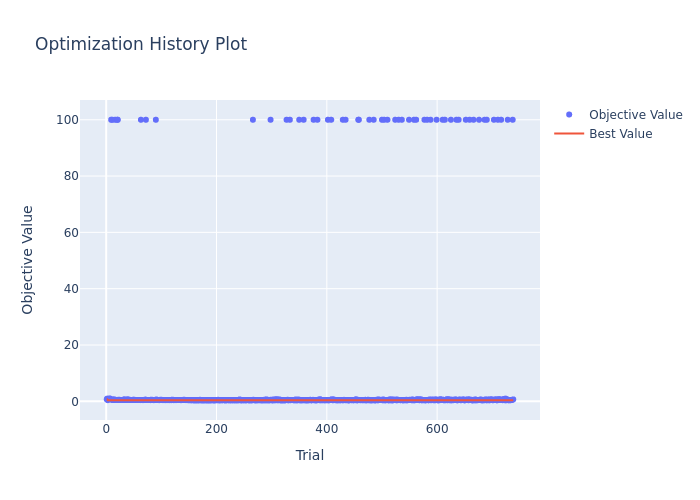

In [12]:
plot_optimization_history(study)

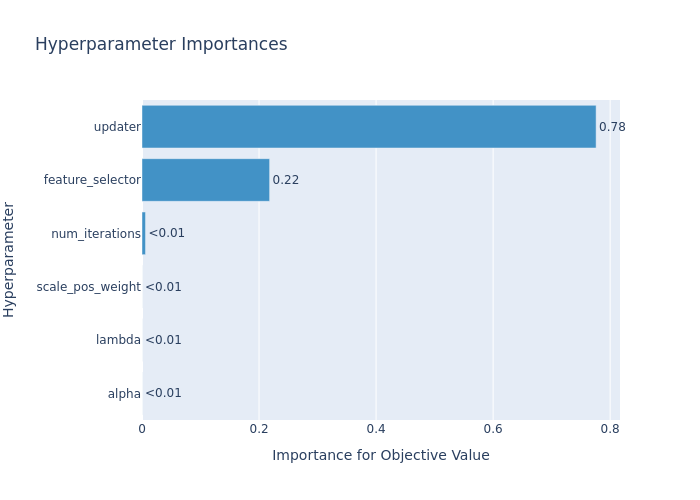

In [13]:
plot_param_importances(study)

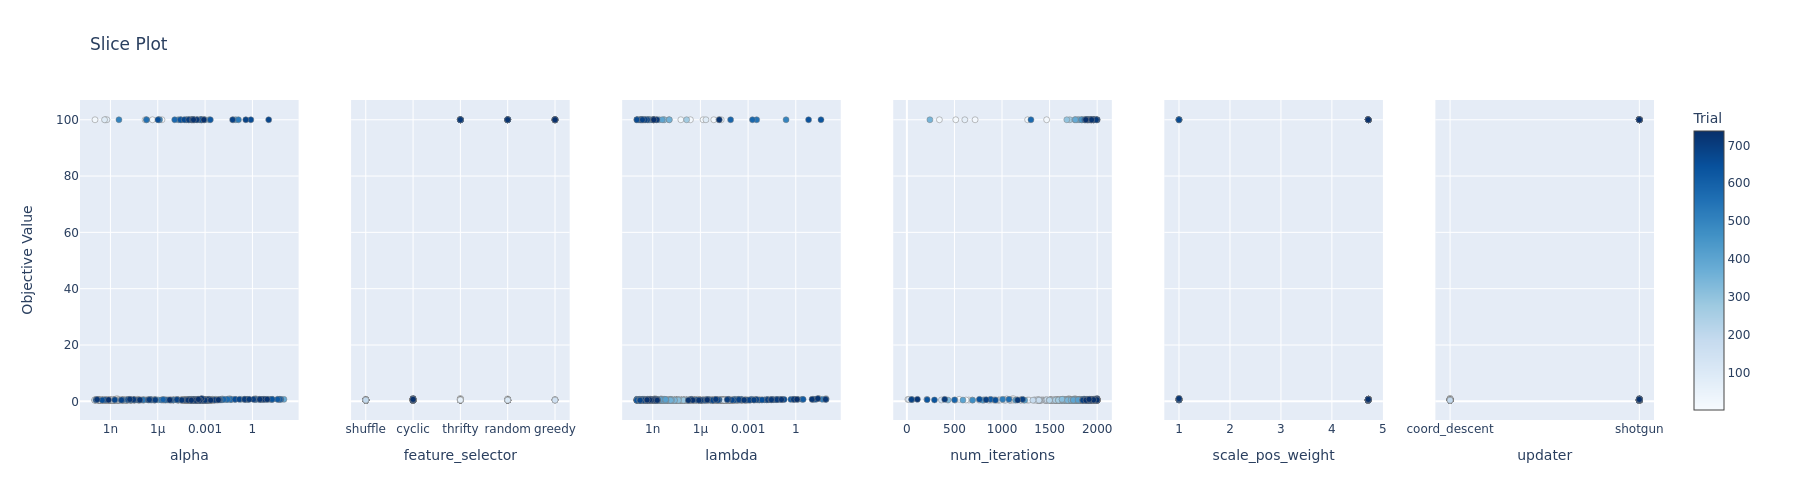

In [14]:
plot_slice(study)

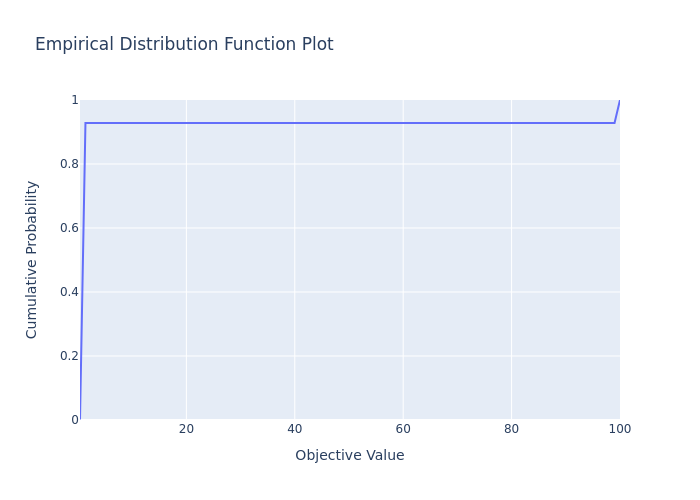

In [15]:
plot_edf(study)

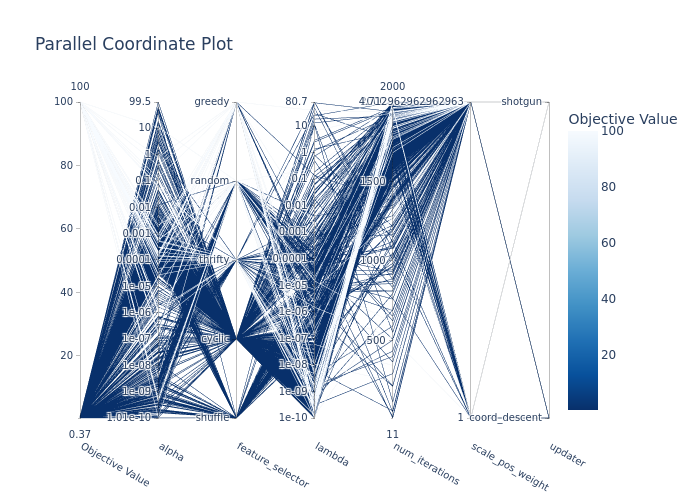

In [16]:
plot_parallel_coordinate(study)

In [17]:
best_params = dict(study.best_params)
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'booster': 'gblinear',
 'objective': 'binary:logistic',
 'verbosity': 2,
 'seed': 2112,
 'eta': 0.005,
 'alpha': 0.0002916325484528911,
 'feature_selector': 'cyclic',
 'lambda': 1.2335024807220584e-09,
 'num_iterations': 1998,
 'scale_pos_weight': 4.712962962962963,
 'updater': 'shotgun'}

***